# Thesis results - From data collected to graphs and insights

## Installing libraries for the Environment

In [ ]:
!pip install pandas
!pip install IPython
!pip install numpy
!pip install matplotlib

In [2]:
import os
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
from   pathlib           import Path
from   IPython.display   import display 

## Data preparation

### Data access

As data was collected on three different systems, with four different CPU configurations testing five different tables, a list for each category is created, so that the code can be iterated easily.

In [17]:
tables = ["results_supplier_tpch_sf1", 
          "results_supplier_tpch_sf10",
          "results_supplier_tpch_sf100", 
          "results_lineitem_tpch_sf1", 
          "results_lineitem_tpch_sf10"]
number_of_rows = {"results_supplier_tpch_sf1": 10000, 
                  "results_supplier_tpch_sf10": 100000, 
                  "results_supplier_tpch_sf100": 1000000, 
                  "results_lineitem_tpch_sf1": 6000000, 
                  "results_lineitem_tpch_sf10": 60000000}
number_of_rows_string = {"results_supplier_tpch_sf1": "10K", 
                         "results_supplier_tpch_sf10": "100K", 
                         "results_supplier_tpch_sf100": "1M", 
                         "results_lineitem_tpch_sf1": "6M", 
                         "results_lineitem_tpch_sf10": "60M"}
CPU_configs = ["1_core", "2_core", "4_core", "8_core"]
systems     = ['HUDI','ICEBERG','DELTA']    #systems = ["HDFS", "LocalFS", "HUDI"] x Giovanni
modes       = ["read", "write"]
metrics     = ["throughput", "time"]

path         = Path('C:/Users/meneghs/Development/laptop_local_repos/thesis/results')
data_path    = path / 'data'
figures_path = path / 'figures'

### Standardize data - Remove extra columns

The data collected from Snurran (production environment), gets saved with an extra column that contains the row number. This is not useful for data analysis purposes, so this column is removed.

In [7]:
old_path = 'something'

for mode in modes:
    for system in systems:
        for CPU_config in CPU_configs:
            for table in tables:
                # Read csv file
                read_path = str(old_path / 'time' / system / CPU_config / table) + '.csv'
                #df = pd.read_csv(data_path + "/" + mode + "/time/" + system + "/" + CPU_config + "/" + table + ".csv")
                df = pd.read_csv(read_path)
                #display(df)
                if (system == "HUDI" and mode == "write" and 
                    not os.path.exists(data_path + "/" + mode + "/time/" + system + "/" + CPU_config + "/" + table + "_DELTAS.csv")):
                    write_list = []
                    df = df[['Upload', 'Materialize', 'Read']]
                    for index, row in df.iterrows():
                        write_list.append(row['Upload'] + row['Materialize'])
                    df['Write'] = write_list
                    df.to_csv(data_path + "/" + mode + "/time/" + system + "/" + CPU_config + "/" + table + "_DELTAS.csv", index=False)
                # Select only Write and Read column
                df = df[[mode.capitalize()]]
                # Save to .csv file without index
                #df.to_csv(data_path + "/" + mode + "/time/" + system + "/" + CPU_config + "/" + table + ".csv", index=False)
                save_path = str(data_path / mode / 'time' / system / CPU_config / table) + '.csv'
                df.to_csv(save_path, index=False)

### Calculate Mean Latency/Time per table with Confidence Interval

A table that for each row contains the mean and confidence interval of the thoughput of a table (table, CPU_config, system)

In [9]:
def bootstrap(x, Nboot, statfun) :
    """ Calculate bootstrap statistics for a sample x """
    x = np.array(x)

    resampled_stat = []
    for k in range (Nboot) :
        index = np.random.randint(0, len(x), len(x))
        sample = x[index]
        resampled_stat.append(statfun(sample))
    
    return np.array(resampled_stat)

In [12]:
Nboot = 1000

for mode in modes:
    results = []
    for system in systems:
        for CPU_config in CPU_configs:
            for table in tables:
                # Read metric from .csv file
                read_path = str(data_path / mode / 'time' / system / CPU_config / table) + '.csv'
                df = pd.read_csv(read_path)
                    
                table_bootstrap = bootstrap(df[mode.capitalize()].to_numpy(), Nboot, np.mean)

                ## Save row of results in results
                results_row = [system, CPU_config, table, np.mean(table_bootstrap), np.percentile(table_bootstrap, 2.5), np.percentile(table_bootstrap, 97.5)]
                results.append(results_row)
        
    ## Create and then save a dataframe with the results in .csv
    df = pd.DataFrame(results, columns =  ["Technology", "CPU_Cores", "Table_name", "Mean", "Low_CI", "High_CI"])
    display(df)
    save_path = str(data_path / mode / mode) + "_time_results.csv"
    df.to_csv(save_path, index=False)

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,1_core,results_supplier_tpch_sf1,0.631443,0.623600,0.640865
1,HUDI,1_core,results_supplier_tpch_sf10,2.650425,2.642771,2.658797
2,HUDI,1_core,results_supplier_tpch_sf100,8.592962,8.324318,8.889649
3,HUDI,1_core,results_lineitem_tpch_sf1,33.525805,33.221214,33.838807
4,HUDI,1_core,results_lineitem_tpch_sf10,33.690308,33.342632,34.035324
5,HUDI,2_core,results_supplier_tpch_sf1,0.624824,0.621805,0.628024
6,HUDI,2_core,results_supplier_tpch_sf10,2.663320,2.656154,2.670704
7,HUDI,2_core,results_supplier_tpch_sf100,8.606869,8.301382,8.979207
8,HUDI,2_core,results_lineitem_tpch_sf1,33.377402,33.096844,33.706813
9,HUDI,2_core,results_lineitem_tpch_sf10,33.628798,33.286167,34.017800


,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,1_core,results_supplier_tpch_sf1,50.237942,49.497732,50.959889
1,HUDI,1_core,results_supplier_tpch_sf10,59.556051,58.911896,60.197333
2,HUDI,1_core,results_supplier_tpch_sf100,112.177731,111.398577,112.961769
3,HUDI,1_core,results_lineitem_tpch_sf1,511.849079,510.652798,512.888998
4,HUDI,1_core,results_lineitem_tpch_sf10,2716.209388,2700.807026,2732.348875
5,HUDI,2_core,results_supplier_tpch_sf1,50.727795,50.115078,51.315972
6,HUDI,2_core,results_supplier_tpch_sf10,59.776468,59.107324,60.482776
7,HUDI,2_core,results_supplier_tpch_sf100,108.564624,108.016957,109.069677
8,HUDI,2_core,results_lineitem_tpch_sf1,473.383095,472.306352,474.453900
9,HUDI,2_core,results_lineitem_tpch_sf10,2341.083593,2334.158495,2347.681423


### Calculate Mean time per table with Confidence Interval - HUDI


In [13]:
def bootstrap(x, Nboot, statfun) :
    """ Calculate bootstrap statistics for a sample x """
    x = np.array(x)

    resampled_stat = []
    for k in range (Nboot) :
        index = np.random.randint(0, len(x), len(x))
        sample = x[index]
        resampled_stat.append(statfun(sample))
    
    return np.array(resampled_stat)

In [14]:
Nboot = 1000

for mode in ["upload", "materialize"]:
    results = []
    for CPU_config in CPU_configs:
        for table in tables:
            # Read .csv file
            read_path = str(data_path / 'write' / 'time' / 'HUDI' / CPU_config / table) + '_DELTAS.csv'
            df = pd.read_csv(read_path)
                
            table_bootstrap = bootstrap(df[mode.capitalize()].to_numpy(), Nboot, np.mean)

            ## Save row of results in results
            results_row = [CPU_config, table, np.mean(table_bootstrap), np.percentile(table_bootstrap, 2.5), np.percentile(table_bootstrap, 97.5)]
            results.append(results_row)
    
    ## Create and then save a dataframe with the results in .csv
    df = pd.DataFrame(results, columns =  ["CPU_Cores", "Table_name", "Mean", "Low_CI", "High_CI"])
    display(df)
    df.to_csv(str(data_path / "write" / "hudi_upload_materialize" / mode) + "_results.csv", index=False)

,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,1_core,results_supplier_tpch_sf1,2.497397,2.390934,2.653199
1,1_core,results_supplier_tpch_sf10,3.668596,3.630522,3.706588
2,1_core,results_supplier_tpch_sf100,22.591116,22.455083,22.719998
3,1_core,results_lineitem_tpch_sf1,244.601174,244.049775,245.162849
4,1_core,results_lineitem_tpch_sf10,2438.216262,2422.751201,2454.152172
5,2_core,results_supplier_tpch_sf1,2.385089,2.322457,2.442754
6,2_core,results_supplier_tpch_sf10,3.435225,3.401373,3.473217
7,2_core,results_supplier_tpch_sf100,18.635611,18.571487,18.709704
8,2_core,results_lineitem_tpch_sf1,205.885304,205.270989,206.509271
9,2_core,results_lineitem_tpch_sf10,2064.141200,2057.455521,2071.065289


,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,1_core,results_supplier_tpch_sf1,47.730447,47.067900,48.367469
1,1_core,results_supplier_tpch_sf10,55.909231,55.213955,56.560619
2,1_core,results_supplier_tpch_sf100,89.600574,88.902661,90.293817
3,1_core,results_lineitem_tpch_sf1,267.254775,266.404711,268.148567
4,1_core,results_lineitem_tpch_sf10,278.159983,276.281382,280.356971
5,2_core,results_supplier_tpch_sf1,48.342561,47.764775,48.950831
6,2_core,results_supplier_tpch_sf10,56.353572,55.623769,57.036606
7,2_core,results_supplier_tpch_sf100,89.932482,89.406006,90.424915
8,2_core,results_lineitem_tpch_sf1,267.514524,266.731842,268.319799
9,2_core,results_lineitem_tpch_sf10,276.964002,275.715158,278.265440


### Calculate Throughput

In [16]:
for mode in modes:
    df = pd.read_csv(str(data_path / mode / mode) + '_time_results.csv')
    df = df.reset_index()

    new_table = []
    for index, row in df.iterrows():
        row["Mean"] = number_of_rows[row["Table_name"]] / row["Mean"]
        tmp = row["High_CI"]
        row["High_CI"] = number_of_rows[row["Table_name"]] / row["Low_CI"]
        row["Low_CI"] = number_of_rows[row["Table_name"]] / tmp
        new_table.append(row)
    
    ## Create and then save a dataframe with the results in .csv
    df = pd.DataFrame(new_table, columns =  ["Technology", "CPU_Cores", "Table_name", "Mean", "Low_CI", "High_CI"])
    display(df)
    df.to_csv(str(data_path / mode / mode) + '_throughput_results.csv', index=False)

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,1_core,results_supplier_tpch_sf1,1.583673e+04,1.560392e+04,1.603591e+04
1,HUDI,1_core,results_supplier_tpch_sf10,3.772979e+04,3.761100e+04,3.783907e+04
2,HUDI,1_core,results_supplier_tpch_sf100,1.163743e+05,1.124904e+05,1.201300e+05
3,HUDI,1_core,results_lineitem_tpch_sf1,1.789666e+05,1.773112e+05,1.806075e+05
4,HUDI,1_core,results_lineitem_tpch_sf10,1.780928e+06,1.762874e+06,1.799498e+06
5,HUDI,2_core,results_supplier_tpch_sf1,1.600450e+04,1.592295e+04,1.608220e+04
6,HUDI,2_core,results_supplier_tpch_sf10,3.754712e+04,3.744331e+04,3.764842e+04
7,HUDI,2_core,results_supplier_tpch_sf100,1.161863e+05,1.113684e+05,1.204619e+05
8,HUDI,2_core,results_lineitem_tpch_sf1,1.797623e+05,1.780056e+05,1.812862e+05
9,HUDI,2_core,results_lineitem_tpch_sf10,1.784185e+06,1.763783e+06,1.802551e+06


,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,1_core,results_supplier_tpch_sf1,1.990527e+02,1.962328e+02,2.020295e+02
1,HUDI,1_core,results_supplier_tpch_sf10,1.679091e+03,1.661203e+03,1.697450e+03
2,HUDI,1_core,results_supplier_tpch_sf100,8.914425e+03,8.852553e+03,8.976775e+03
3,HUDI,1_core,results_lineitem_tpch_sf1,1.172221e+04,1.169844e+04,1.174967e+04
4,HUDI,1_core,results_lineitem_tpch_sf10,2.208961e+04,2.195913e+04,2.221558e+04
5,HUDI,2_core,results_supplier_tpch_sf1,1.971306e+02,1.948711e+02,1.995407e+02
6,HUDI,2_core,results_supplier_tpch_sf10,1.672899e+03,1.653363e+03,1.691838e+03
7,HUDI,2_core,results_supplier_tpch_sf100,9.211104e+03,9.168451e+03,9.257806e+03
8,HUDI,2_core,results_lineitem_tpch_sf1,1.267472e+04,1.264612e+04,1.270362e+04
9,HUDI,2_core,results_lineitem_tpch_sf10,2.562916e+04,2.555713e+04,2.570520e+04


## Display results - Hudi vs. Iceberg vs. Delta

In [45]:
dest_folder = 'hudi_iceberg_delta'

### Throughput metric on Read and Writes

#### Write operations - Throughput

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,1_core,results_supplier_tpch_sf1,1.990527e+02,1.962328e+02,2.020295e+02
1,HUDI,1_core,results_supplier_tpch_sf10,1.679091e+03,1.661203e+03,1.697450e+03
2,HUDI,1_core,results_supplier_tpch_sf100,8.914425e+03,8.852553e+03,8.976775e+03
3,HUDI,1_core,results_lineitem_tpch_sf1,1.172221e+04,1.169844e+04,1.174967e+04
4,HUDI,1_core,results_lineitem_tpch_sf10,2.208961e+04,2.195913e+04,2.221558e+04
5,ICEBERG,1_core,results_supplier_tpch_sf1,8.305214e+03,8.097477e+03,8.552137e+03
6,ICEBERG,1_core,results_supplier_tpch_sf10,7.903658e+04,7.697409e+04,8.186664e+04
7,ICEBERG,1_core,results_supplier_tpch_sf100,5.821730e+05,5.577264e+05,6.014118e+05
8,ICEBERG,1_core,results_lineitem_tpch_sf1,1.677622e+06,1.660186e+06,1.697038e+06
9,ICEBERG,1_core,results_lineitem_tpch_sf10,2.438045e+06,2.420738e+06,2.453683e+06


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1195772637.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1195772637.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


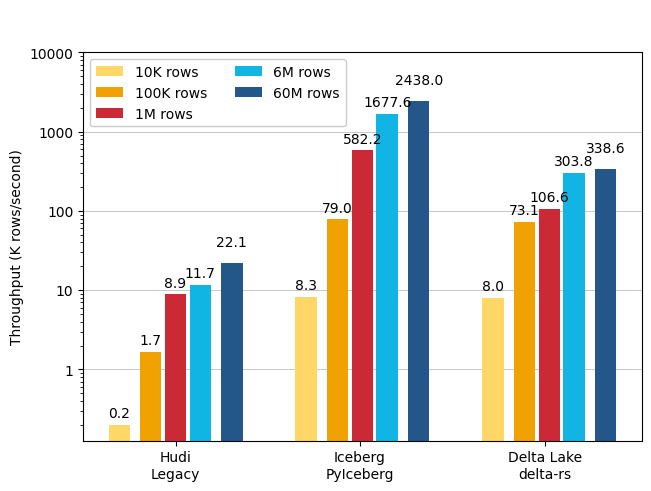

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,2_core,results_supplier_tpch_sf1,1.971306e+02,1.948711e+02,1.995407e+02
1,HUDI,2_core,results_supplier_tpch_sf10,1.672899e+03,1.653363e+03,1.691838e+03
2,HUDI,2_core,results_supplier_tpch_sf100,9.211104e+03,9.168451e+03,9.257806e+03
3,HUDI,2_core,results_lineitem_tpch_sf1,1.267472e+04,1.264612e+04,1.270362e+04
4,HUDI,2_core,results_lineitem_tpch_sf10,2.562916e+04,2.555713e+04,2.570520e+04
5,ICEBERG,2_core,results_supplier_tpch_sf1,8.367702e+03,7.935558e+03,8.816102e+03
6,ICEBERG,2_core,results_supplier_tpch_sf10,8.336001e+04,7.983944e+04,8.763880e+04
7,ICEBERG,2_core,results_supplier_tpch_sf100,5.808951e+05,5.719956e+05,5.903113e+05
8,ICEBERG,2_core,results_lineitem_tpch_sf1,1.682394e+06,1.646514e+06,1.712942e+06
9,ICEBERG,2_core,results_lineitem_tpch_sf10,2.552340e+06,2.548181e+06,2.557028e+06


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1195772637.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1195772637.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


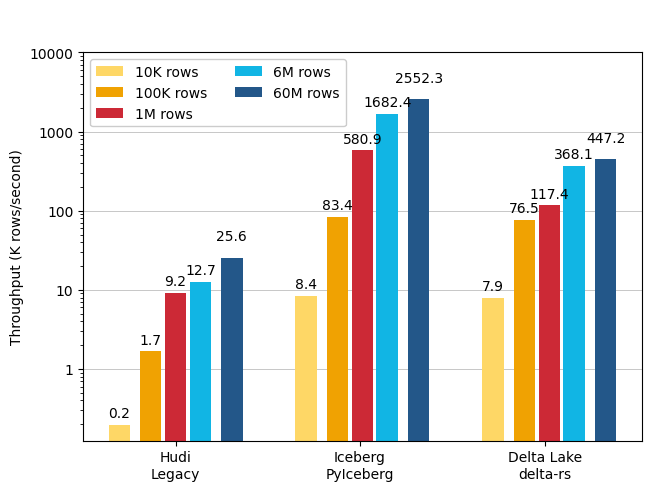

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,4_core,results_supplier_tpch_sf1,1.950403e+02,1.926119e+02,1.975900e+02
1,HUDI,4_core,results_supplier_tpch_sf10,1.680277e+03,1.662859e+03,1.699087e+03
2,HUDI,4_core,results_supplier_tpch_sf100,9.190566e+03,9.143293e+03,9.234340e+03
3,HUDI,4_core,results_lineitem_tpch_sf1,1.244920e+04,1.242493e+04,1.247441e+04
4,HUDI,4_core,results_lineitem_tpch_sf10,2.557426e+04,2.547541e+04,2.567201e+04
5,ICEBERG,4_core,results_supplier_tpch_sf1,8.366270e+03,8.152667e+03,8.613256e+03
6,ICEBERG,4_core,results_supplier_tpch_sf10,7.969715e+04,7.781650e+04,8.205281e+04
7,ICEBERG,4_core,results_supplier_tpch_sf100,6.128914e+05,5.977475e+05,6.303630e+05
8,ICEBERG,4_core,results_lineitem_tpch_sf1,1.692583e+06,1.680056e+06,1.707255e+06
9,ICEBERG,4_core,results_lineitem_tpch_sf10,2.499443e+06,2.484092e+06,2.510769e+06


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1195772637.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1195772637.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


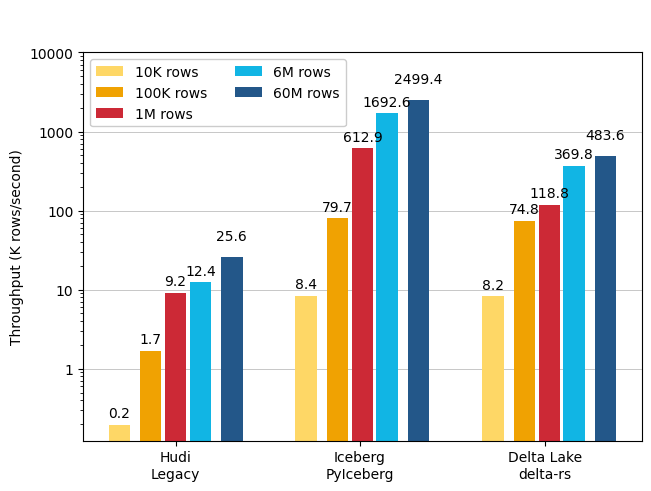

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,8_core,results_supplier_tpch_sf1,1.952135e+02,1.929522e+02,1.976781e+02
1,HUDI,8_core,results_supplier_tpch_sf10,1.658703e+03,1.645636e+03,1.672839e+03
2,HUDI,8_core,results_supplier_tpch_sf100,9.142290e+03,9.103097e+03,9.181792e+03
3,HUDI,8_core,results_lineitem_tpch_sf1,1.260576e+04,1.257541e+04,1.263669e+04
4,HUDI,8_core,results_lineitem_tpch_sf10,2.580859e+04,2.573909e+04,2.587143e+04
5,ICEBERG,8_core,results_supplier_tpch_sf1,8.208728e+03,7.747348e+03,8.627100e+03
6,ICEBERG,8_core,results_supplier_tpch_sf10,8.009089e+04,7.835219e+04,8.197734e+04
7,ICEBERG,8_core,results_supplier_tpch_sf100,5.817078e+05,5.775340e+05,5.868194e+05
8,ICEBERG,8_core,results_lineitem_tpch_sf1,1.698521e+06,1.662196e+06,1.727431e+06
9,ICEBERG,8_core,results_lineitem_tpch_sf10,2.539884e+06,2.531592e+06,2.546589e+06


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1195772637.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1195772637.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


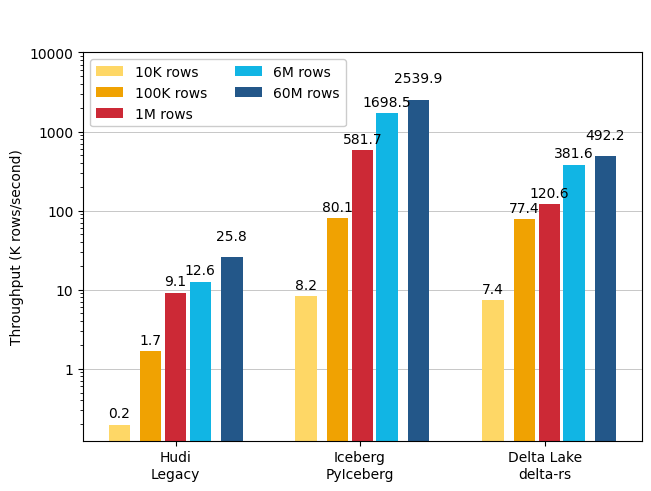

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Read csv file
df = pd.read_csv(data_path / "write" / "write_throughput_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[df["CPU_Cores"] == CPU_config].copy().reset_index(drop=True)

    display(df_filtered)
    df_filtered.to_csv(str(data_path / "write" / "filtered_data" / "write_throughput_results") + CPU_config + ".csv", index=False)

    technologies = ("Hudi\nLegacy", "Iceberg\nPyIceberg", "Delta Lake\ndelta-rs")
    write_means = {
        '10K rows':   (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5], df_filtered["Mean"].iloc[10]),
        '100K rows':  (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6], df_filtered["Mean"].iloc[11]),
        '1M rows': (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7], df_filtered["Mean"].iloc[12]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8], df_filtered["Mean"].iloc[13]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9], df_filtered["Mean"].iloc[14]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115, 0.235])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.1f}".format(float(x / 1000)), padding= 3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Throughput (K rows/second)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper left', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 10000000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)
    
    plt.savefig(str(figures_path / 'write'/ dest_folder / "write_throughput_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

#### Read Operations - Throughput

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,1_core,results_supplier_tpch_sf1,1.583673e+04,1.560392e+04,1.603591e+04
1,HUDI,1_core,results_supplier_tpch_sf10,3.772979e+04,3.761100e+04,3.783907e+04
2,HUDI,1_core,results_supplier_tpch_sf100,1.163743e+05,1.124904e+05,1.201300e+05
3,HUDI,1_core,results_lineitem_tpch_sf1,1.789666e+05,1.773112e+05,1.806075e+05
4,HUDI,1_core,results_lineitem_tpch_sf10,1.780928e+06,1.762874e+06,1.799498e+06
5,ICEBERG,1_core,results_supplier_tpch_sf1,5.804800e+05,5.555953e+05,6.076455e+05
6,ICEBERG,1_core,results_supplier_tpch_sf10,2.133404e+06,1.958119e+06,2.334613e+06
7,ICEBERG,1_core,results_supplier_tpch_sf100,2.324630e+06,2.262967e+06,2.381662e+06
8,ICEBERG,1_core,results_lineitem_tpch_sf1,2.825777e+06,2.804612e+06,2.846731e+06
9,ICEBERG,1_core,results_lineitem_tpch_sf10,2.749828e+06,2.735099e+06,2.765125e+06


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3764686544.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3764686544.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


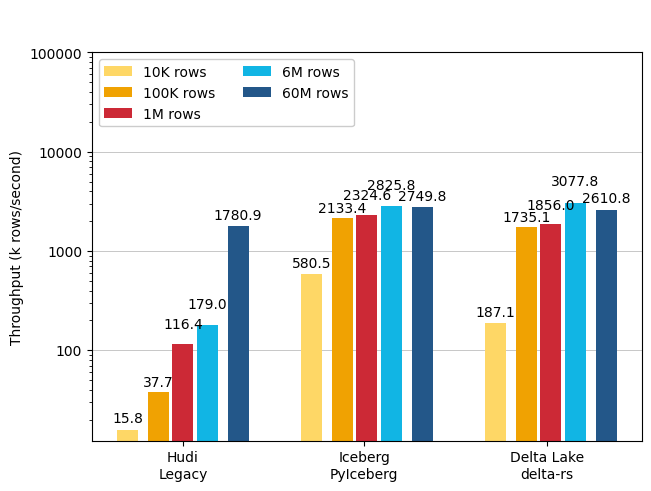

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,2_core,results_supplier_tpch_sf1,1.600450e+04,1.592295e+04,1.608220e+04
1,HUDI,2_core,results_supplier_tpch_sf10,3.754712e+04,3.744331e+04,3.764842e+04
2,HUDI,2_core,results_supplier_tpch_sf100,1.161863e+05,1.113684e+05,1.204619e+05
3,HUDI,2_core,results_lineitem_tpch_sf1,1.797623e+05,1.780056e+05,1.812862e+05
4,HUDI,2_core,results_lineitem_tpch_sf10,1.784185e+06,1.763783e+06,1.802551e+06
5,ICEBERG,2_core,results_supplier_tpch_sf1,5.457584e+05,5.177570e+05,5.763674e+05
6,ICEBERG,2_core,results_supplier_tpch_sf10,2.316163e+06,2.213607e+06,2.413482e+06
7,ICEBERG,2_core,results_supplier_tpch_sf100,3.711542e+06,3.614794e+06,3.814373e+06
8,ICEBERG,2_core,results_lineitem_tpch_sf1,4.629433e+06,4.464785e+06,4.877936e+06
9,ICEBERG,2_core,results_lineitem_tpch_sf10,4.440187e+06,4.403743e+06,4.474117e+06


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3764686544.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3764686544.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


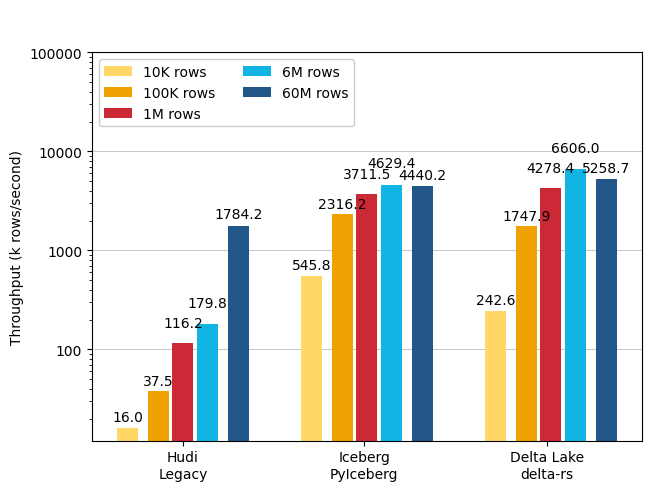

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,4_core,results_supplier_tpch_sf1,1.571731e+04,1.516413e+04,1.603729e+04
1,HUDI,4_core,results_supplier_tpch_sf10,3.788087e+04,3.778617e+04,3.797227e+04
2,HUDI,4_core,results_supplier_tpch_sf100,1.143594e+05,1.111053e+05,1.173386e+05
3,HUDI,4_core,results_lineitem_tpch_sf1,1.793857e+05,1.778273e+05,1.808006e+05
4,HUDI,4_core,results_lineitem_tpch_sf10,1.782450e+06,1.760007e+06,1.803800e+06
5,ICEBERG,4_core,results_supplier_tpch_sf1,3.356574e+05,1.691043e+05,6.378219e+05
6,ICEBERG,4_core,results_supplier_tpch_sf10,2.334622e+06,2.235354e+06,2.431532e+06
7,ICEBERG,4_core,results_supplier_tpch_sf100,4.285053e+06,4.031244e+06,4.575643e+06
8,ICEBERG,4_core,results_lineitem_tpch_sf1,5.949035e+06,5.904555e+06,5.992630e+06
9,ICEBERG,4_core,results_lineitem_tpch_sf10,5.934547e+06,5.891986e+06,5.975559e+06


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3764686544.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3764686544.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


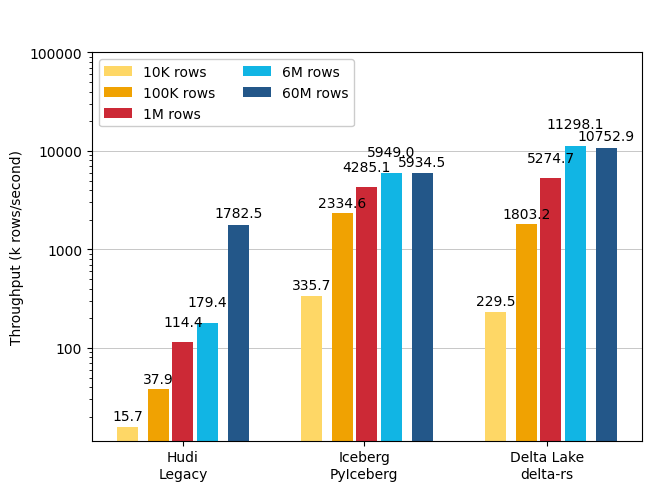

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,8_core,results_supplier_tpch_sf1,1.594066e+04,1.581039e+04,1.606327e+04
1,HUDI,8_core,results_supplier_tpch_sf10,3.756087e+04,3.742290e+04,3.769000e+04
2,HUDI,8_core,results_supplier_tpch_sf100,1.197298e+05,1.160319e+05,1.228255e+05
3,HUDI,8_core,results_lineitem_tpch_sf1,1.794252e+05,1.777644e+05,1.808876e+05
4,HUDI,8_core,results_lineitem_tpch_sf10,1.810368e+06,1.796115e+06,1.823668e+06
5,ICEBERG,8_core,results_supplier_tpch_sf1,5.895188e+05,5.524021e+05,6.258719e+05
6,ICEBERG,8_core,results_supplier_tpch_sf10,2.343108e+06,2.233190e+06,2.441607e+06
7,ICEBERG,8_core,results_supplier_tpch_sf100,4.308144e+06,4.249776e+06,4.361608e+06
8,ICEBERG,8_core,results_lineitem_tpch_sf1,6.782336e+06,6.707349e+06,6.852172e+06
9,ICEBERG,8_core,results_lineitem_tpch_sf10,6.787944e+06,6.715992e+06,6.850141e+06


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3764686544.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3764686544.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


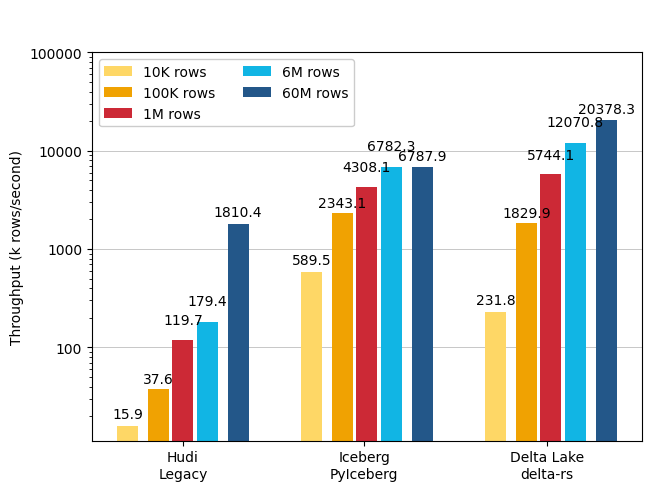

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Read csv file
df = pd.read_csv(data_path / "read" / "read_throughput_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[df["CPU_Cores"] == CPU_config].copy().reset_index(drop=True)
    
    display(df_filtered)
    df_filtered.to_csv(str(data_path / "read" / "filtered_data" / "read_throughput_results") + CPU_config + ".csv", index=False)

    technologies = ("Hudi\nLegacy", "Iceberg\nPyIceberg", "Delta Lake\ndelta-rs")
    write_means = {
        '10K rows':   (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5], df_filtered["Mean"].iloc[10]),
        '100K rows':  (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6], df_filtered["Mean"].iloc[11]),
        '1M rows': (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7], df_filtered["Mean"].iloc[12]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8], df_filtered["Mean"].iloc[13]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9], df_filtered["Mean"].iloc[14]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars

    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115, 0.235])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: -1, 2: 6, 3: 7, 4: 0,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.1f}".format(float(x / 1000)), padding=3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Throughput (k rows/second)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper left', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 100000000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)

    plt.savefig(str(figures_path / 'read'/ dest_folder / "read_throughput_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

### Time/Latency metric on read and writes

#### Write operations - Time/Latency

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,1_core,results_supplier_tpch_sf1,50.237942,49.497732,50.959889
1,HUDI,1_core,results_supplier_tpch_sf10,59.556051,58.911896,60.197333
2,HUDI,1_core,results_supplier_tpch_sf100,112.177731,111.398577,112.961769
3,HUDI,1_core,results_lineitem_tpch_sf1,511.849079,510.652798,512.888998
4,HUDI,1_core,results_lineitem_tpch_sf10,2716.209388,2700.807026,2732.348875
5,ICEBERG,1_core,results_supplier_tpch_sf1,1.204063,1.169298,1.234953
6,ICEBERG,1_core,results_supplier_tpch_sf10,1.265237,1.221499,1.299138
7,ICEBERG,1_core,results_supplier_tpch_sf100,1.717703,1.662754,1.792994
8,ICEBERG,1_core,results_lineitem_tpch_sf1,3.576492,3.535571,3.614053
9,ICEBERG,1_core,results_lineitem_tpch_sf10,24.609887,24.453035,24.785828


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\937118176.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\937118176.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


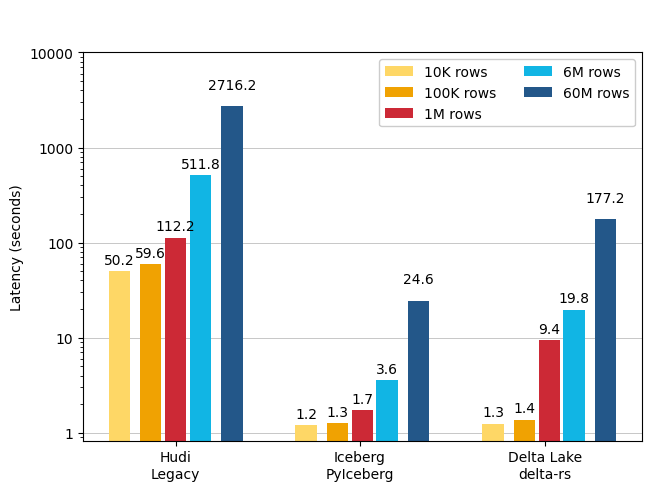

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,2_core,results_supplier_tpch_sf1,50.727795,50.115078,51.315972
1,HUDI,2_core,results_supplier_tpch_sf10,59.776468,59.107324,60.482776
2,HUDI,2_core,results_supplier_tpch_sf100,108.564624,108.016957,109.069677
3,HUDI,2_core,results_lineitem_tpch_sf1,473.383095,472.306352,474.453900
4,HUDI,2_core,results_lineitem_tpch_sf10,2341.083593,2334.158495,2347.681423
5,ICEBERG,2_core,results_supplier_tpch_sf1,1.195071,1.134288,1.260151
6,ICEBERG,2_core,results_supplier_tpch_sf10,1.199616,1.141047,1.252514
7,ICEBERG,2_core,results_supplier_tpch_sf100,1.721481,1.694022,1.748265
8,ICEBERG,2_core,results_lineitem_tpch_sf1,3.566346,3.502745,3.644062
9,ICEBERG,2_core,results_lineitem_tpch_sf10,23.507838,23.464740,23.546208


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\937118176.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\937118176.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


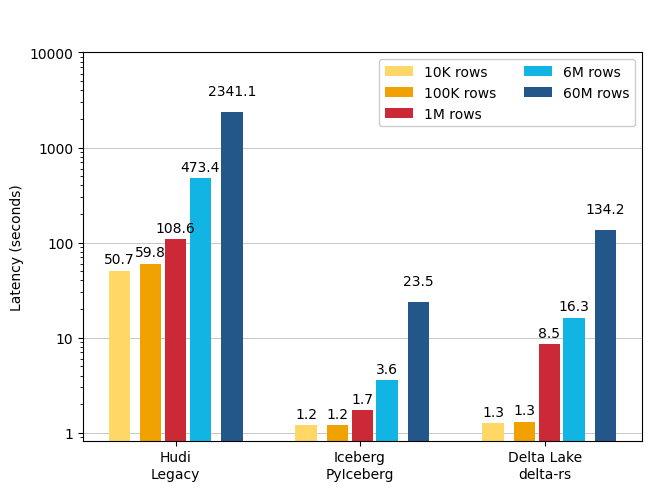

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,4_core,results_supplier_tpch_sf1,51.271457,50.609850,51.917871
1,HUDI,4_core,results_supplier_tpch_sf10,59.514008,58.855121,60.137372
2,HUDI,4_core,results_supplier_tpch_sf100,108.807226,108.291444,109.369790
3,HUDI,4_core,results_lineitem_tpch_sf1,481.958703,480.984720,482.900191
4,HUDI,4_core,results_lineitem_tpch_sf10,2346.108731,2337.175803,2355.212329
5,ICEBERG,4_core,results_supplier_tpch_sf1,1.195276,1.161001,1.226592
6,ICEBERG,4_core,results_supplier_tpch_sf10,1.254750,1.218727,1.285074
7,ICEBERG,4_core,results_supplier_tpch_sf100,1.631610,1.586387,1.672947
8,ICEBERG,4_core,results_lineitem_tpch_sf1,3.544877,3.514413,3.571311
9,ICEBERG,4_core,results_lineitem_tpch_sf10,24.005346,23.897063,24.153696


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\937118176.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\937118176.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


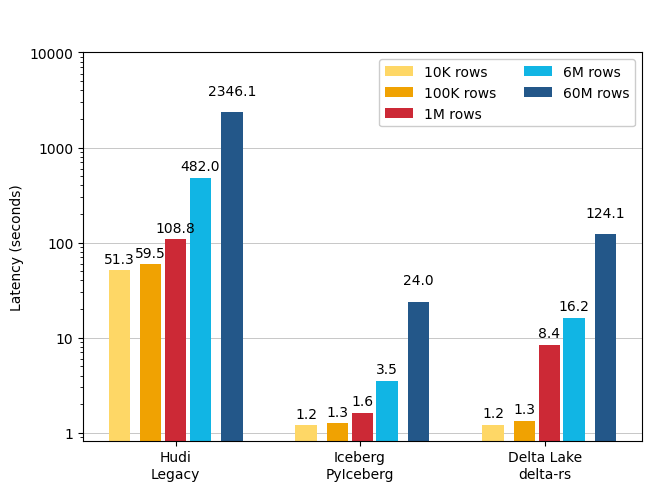

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,8_core,results_supplier_tpch_sf1,51.225978,50.587301,51.826303
1,HUDI,8_core,results_supplier_tpch_sf10,60.288080,59.778629,60.766768
2,HUDI,8_core,results_supplier_tpch_sf100,109.381786,108.911206,109.852718
3,HUDI,8_core,results_lineitem_tpch_sf1,475.972839,474.807877,477.121642
4,HUDI,8_core,results_lineitem_tpch_sf10,2324.807399,2319.160361,2331.084597
5,ICEBERG,8_core,results_supplier_tpch_sf1,1.218216,1.159138,1.290764
6,ICEBERG,8_core,results_supplier_tpch_sf10,1.248581,1.219849,1.276288
7,ICEBERG,8_core,results_supplier_tpch_sf100,1.719076,1.704102,1.731500
8,ICEBERG,8_core,results_lineitem_tpch_sf1,3.532484,3.473366,3.609682
9,ICEBERG,8_core,results_lineitem_tpch_sf10,23.623125,23.560928,23.700506


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\937118176.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\937118176.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


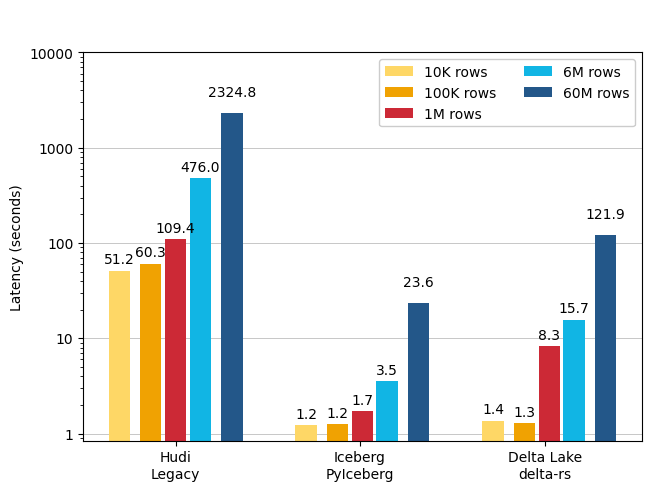

In [ ]:
# Read csv file
df = pd.read_csv(data_path / "write" / "write_time_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[df["CPU_Cores"] == CPU_config].copy().reset_index(drop=True)

    display(df_filtered)
    df_filtered.to_csv(str(data_path / "write" / "filtered_data" / "write_time_results") + CPU_config + ".csv", index=False)

    technologies = ("Hudi\nLegacy", "Iceberg\nPyIceberg", "Delta Lake\ndelta-rs")
    write_means = {
        '10K rows':   (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5], df_filtered["Mean"].iloc[10]),
        '100K rows':  (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6], df_filtered["Mean"].iloc[11]),
        '1M rows': (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7], df_filtered["Mean"].iloc[12]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8], df_filtered["Mean"].iloc[13]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9], df_filtered["Mean"].iloc[14]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115, 0.235])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.1f}".format(float(x)), padding= 3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Latency (seconds)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper right', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 10000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)
    
    plt.savefig(str(figures_path / 'write'/ dest_folder / "write_time_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

#### Read Operations - Time/Latency

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,1_core,results_supplier_tpch_sf1,0.631443,0.623600,0.640865
1,HUDI,1_core,results_supplier_tpch_sf10,2.650425,2.642771,2.658797
2,HUDI,1_core,results_supplier_tpch_sf100,8.592962,8.324318,8.889649
3,HUDI,1_core,results_lineitem_tpch_sf1,33.525805,33.221214,33.838807
4,HUDI,1_core,results_lineitem_tpch_sf10,33.690308,33.342632,34.035324
5,ICEBERG,1_core,results_supplier_tpch_sf1,0.017227,0.016457,0.017999
6,ICEBERG,1_core,results_supplier_tpch_sf10,0.046873,0.042834,0.051069
7,ICEBERG,1_core,results_supplier_tpch_sf100,0.430176,0.419875,0.441898
8,ICEBERG,1_core,results_lineitem_tpch_sf1,2.123310,2.107681,2.139333
9,ICEBERG,1_core,results_lineitem_tpch_sf10,21.819550,21.698837,21.937048


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4215624178.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4215624178.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


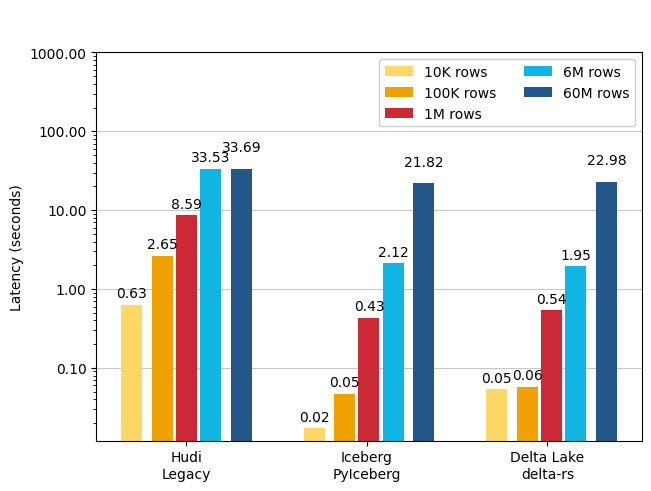

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,2_core,results_supplier_tpch_sf1,0.624824,0.621805,0.628024
1,HUDI,2_core,results_supplier_tpch_sf10,2.663320,2.656154,2.670704
2,HUDI,2_core,results_supplier_tpch_sf100,8.606869,8.301382,8.979207
3,HUDI,2_core,results_lineitem_tpch_sf1,33.377402,33.096844,33.706813
4,HUDI,2_core,results_lineitem_tpch_sf10,33.628798,33.286167,34.017800
5,ICEBERG,2_core,results_supplier_tpch_sf1,0.018323,0.017350,0.019314
6,ICEBERG,2_core,results_supplier_tpch_sf10,0.043175,0.041434,0.045175
7,ICEBERG,2_core,results_supplier_tpch_sf100,0.269430,0.262166,0.276641
8,ICEBERG,2_core,results_lineitem_tpch_sf1,1.296055,1.230028,1.343850
9,ICEBERG,2_core,results_lineitem_tpch_sf10,13.512944,13.410467,13.624773


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4215624178.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4215624178.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


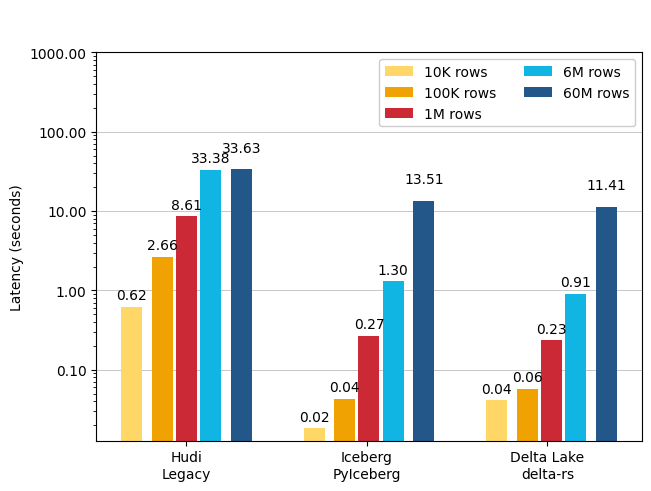

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,4_core,results_supplier_tpch_sf1,0.636241,0.623547,0.659451
1,HUDI,4_core,results_supplier_tpch_sf10,2.639855,2.633501,2.646471
2,HUDI,4_core,results_supplier_tpch_sf100,8.744363,8.522348,9.000468
3,HUDI,4_core,results_lineitem_tpch_sf1,33.447487,33.185726,33.740599
4,HUDI,4_core,results_lineitem_tpch_sf10,33.661529,33.263117,34.090778
5,ICEBERG,4_core,results_supplier_tpch_sf1,0.029792,0.015678,0.059135
6,ICEBERG,4_core,results_supplier_tpch_sf10,0.042833,0.041126,0.044736
7,ICEBERG,4_core,results_supplier_tpch_sf100,0.233369,0.218549,0.248062
8,ICEBERG,4_core,results_lineitem_tpch_sf1,1.008567,1.001230,1.016165
9,ICEBERG,4_core,results_lineitem_tpch_sf10,10.110292,10.040902,10.183323


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4215624178.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4215624178.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


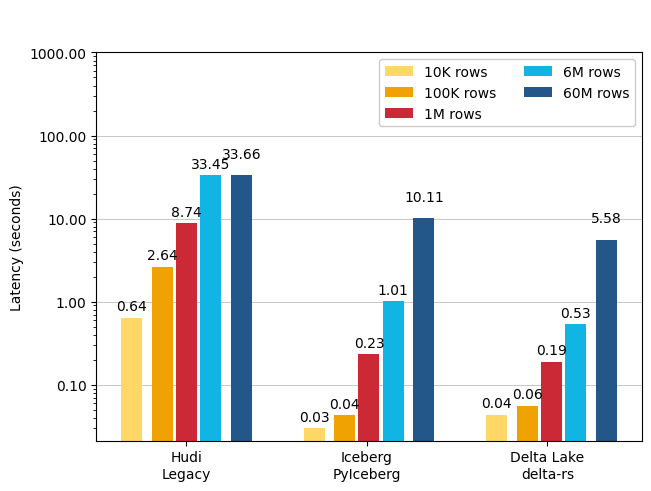

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HUDI,8_core,results_supplier_tpch_sf1,0.627326,0.622538,0.632496
1,HUDI,8_core,results_supplier_tpch_sf10,2.662345,2.653224,2.672161
2,HUDI,8_core,results_supplier_tpch_sf100,8.352139,8.141629,8.618321
3,HUDI,8_core,results_lineitem_tpch_sf1,33.440127,33.169776,33.752544
4,HUDI,8_core,results_lineitem_tpch_sf10,33.142438,32.900727,33.405442
5,ICEBERG,8_core,results_supplier_tpch_sf1,0.016963,0.015978,0.018103
6,ICEBERG,8_core,results_supplier_tpch_sf10,0.042678,0.040957,0.044779
7,ICEBERG,8_core,results_supplier_tpch_sf100,0.232119,0.229273,0.235307
8,ICEBERG,8_core,results_lineitem_tpch_sf1,0.884651,0.875635,0.894541
9,ICEBERG,8_core,results_lineitem_tpch_sf10,8.839201,8.758944,8.933900


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4215624178.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4215624178.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


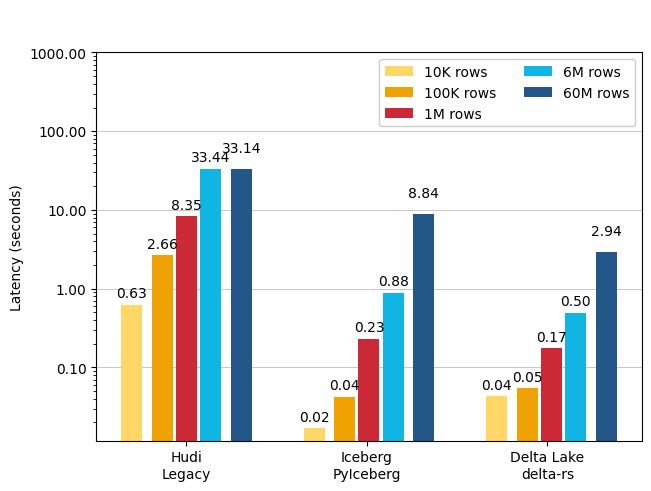

In [ ]:
# Read csv file
df = pd.read_csv(data_path / "read" / "read_time_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[df["CPU_Cores"] == CPU_config].copy().reset_index(drop=True)

    display(df_filtered)
    df_filtered.to_csv(str(data_path / "read" / "filtered_data" / "read_time_results") + CPU_config + ".csv", index=False)

    technologies = ("Hudi\nLegacy", "Iceberg\nPyIceberg", "Delta Lake\ndelta-rs")
    write_means = {
        '10K rows':   (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5], df_filtered["Mean"].iloc[10]),
        '100K rows':  (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6], df_filtered["Mean"].iloc[11]),
        '1M rows': (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7], df_filtered["Mean"].iloc[12]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8], df_filtered["Mean"].iloc[13]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9], df_filtered["Mean"].iloc[14]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115, 0.235])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.2f}".format(float(x)), padding= 3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Latency (seconds)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper right', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 1000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)
    
    plt.savefig(str(figures_path / 'read'/ dest_folder / "read_time_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

### Comparative table HUDI Spark-Kafka time distribution

Filtered Upload


,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,1_core,results_supplier_tpch_sf1,2.497397,2.390934,2.653199
1,1_core,results_supplier_tpch_sf10,3.668596,3.630522,3.706588
2,1_core,results_supplier_tpch_sf100,22.591116,22.455083,22.719998
3,1_core,results_lineitem_tpch_sf1,244.601174,244.049775,245.162849
4,1_core,results_lineitem_tpch_sf10,2438.216262,2422.751201,2454.152172


Filtered Materialize


,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,1_core,results_supplier_tpch_sf1,47.730447,47.067900,48.367469
1,1_core,results_supplier_tpch_sf10,55.909231,55.213955,56.560619
2,1_core,results_supplier_tpch_sf100,89.600574,88.902661,90.293817
3,1_core,results_lineitem_tpch_sf1,267.254775,266.404711,268.148567
4,1_core,results_lineitem_tpch_sf10,278.159983,276.281382,280.356971


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\2496317143.py:50: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5000)


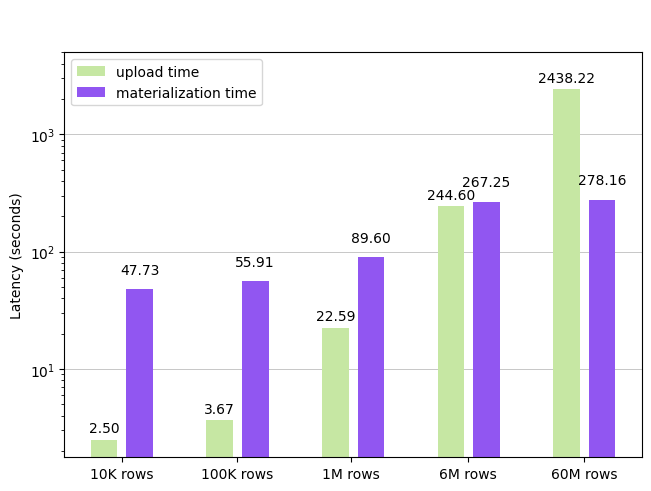

Filtered Upload


,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,2_core,results_supplier_tpch_sf1,2.385089,2.322457,2.442754
1,2_core,results_supplier_tpch_sf10,3.435225,3.401373,3.473217
2,2_core,results_supplier_tpch_sf100,18.635611,18.571487,18.709704
3,2_core,results_lineitem_tpch_sf1,205.885304,205.270989,206.509271
4,2_core,results_lineitem_tpch_sf10,2064.141200,2057.455521,2071.065289


Filtered Materialize


,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,2_core,results_supplier_tpch_sf1,48.342561,47.764775,48.950831
1,2_core,results_supplier_tpch_sf10,56.353572,55.623769,57.036606
2,2_core,results_supplier_tpch_sf100,89.932482,89.406006,90.424915
3,2_core,results_lineitem_tpch_sf1,267.514524,266.731842,268.319799
4,2_core,results_lineitem_tpch_sf10,276.964002,275.715158,278.265440


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\2496317143.py:50: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5000)


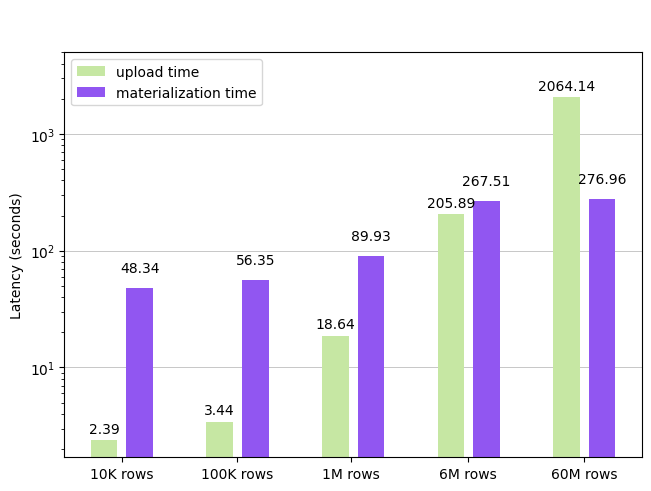

Filtered Upload


,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,4_core,results_supplier_tpch_sf1,2.384177,2.329560,2.433713
1,4_core,results_supplier_tpch_sf10,3.464513,3.426820,3.508230
2,4_core,results_supplier_tpch_sf100,19.230071,19.146399,19.314052
3,4_core,results_lineitem_tpch_sf1,211.661055,211.044560,212.248034
4,4_core,results_lineitem_tpch_sf10,2068.317255,2059.500380,2077.157145


Filtered Materialize


,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,4_core,results_supplier_tpch_sf1,48.904980,48.220207,49.586126
1,4_core,results_supplier_tpch_sf10,56.075641,55.481380,56.708237
2,4_core,results_supplier_tpch_sf100,89.593890,89.030685,90.113275
3,4_core,results_lineitem_tpch_sf1,270.338316,269.581375,271.029589
4,4_core,results_lineitem_tpch_sf10,277.602222,276.096706,279.170416


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\2496317143.py:50: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5000)


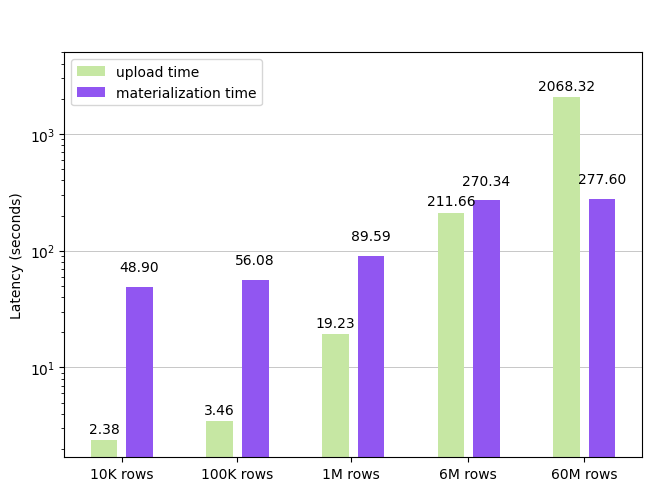

Filtered Upload


,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,8_core,results_supplier_tpch_sf1,2.381210,2.327637,2.432363
1,8_core,results_supplier_tpch_sf10,3.438388,3.410119,3.468825
2,8_core,results_supplier_tpch_sf100,18.865502,18.780080,18.955563
3,8_core,results_lineitem_tpch_sf1,207.683185,207.137635,208.224183
4,8_core,results_lineitem_tpch_sf10,2049.098208,2043.239682,2055.628403


Filtered Materialize


,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,8_core,results_supplier_tpch_sf1,48.836649,48.187809,49.440584
1,8_core,results_supplier_tpch_sf10,56.849628,56.358314,57.323390
2,8_core,results_supplier_tpch_sf100,90.520944,90.063605,90.974660
3,8_core,results_lineitem_tpch_sf1,268.303030,267.431371,269.194170
4,8_core,results_lineitem_tpch_sf10,275.772049,274.265165,277.315295


C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\2496317143.py:50: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5000)


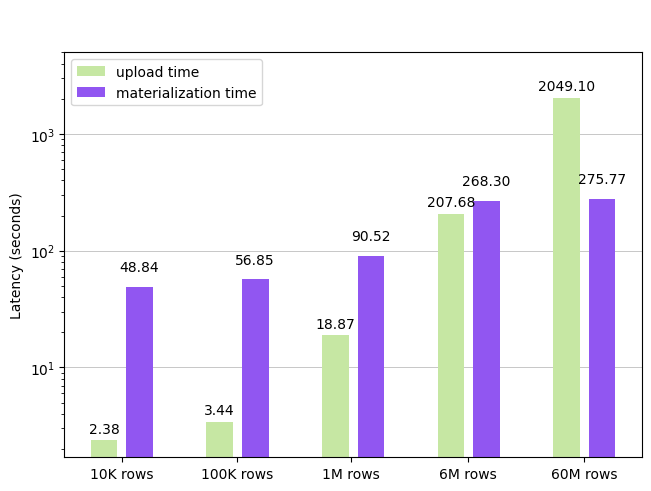

In [39]:
import matplotlib.pyplot as plt
import numpy as np

str(data_path / 'write' / 'hudi_upload_materialize' / 'materialize_results.csv')
# Read csv file
df_upload = pd.read_csv(str(data_path / 'write' / 'hudi_upload_materialize' / 'upload_results.csv'))
df_materialize = pd.read_csv(str(data_path / 'write' / 'hudi_upload_materialize' / 'materialize_results.csv'))
 
for CPU_config in CPU_configs:
    df_upload_filtered = df_upload.loc[df_upload["CPU_Cores"] == CPU_config].copy().reset_index(drop=True)
    df_materialize_filtered = df_materialize.loc[df_materialize["CPU_Cores"] == CPU_config].copy().reset_index(drop=True)
    
    print("Filtered Upload")
    display(df_upload_filtered)
    print("Filtered Materialize")
    display(df_materialize_filtered)

    labels_tables = ("10K rows", "100K rows", "1M rows", "6M rows", "60M rows")
    means = {
        'upload time': (df_upload_filtered["Mean"].iloc[0], df_upload_filtered["Mean"].iloc[1], df_upload_filtered["Mean"].iloc[2], df_upload_filtered["Mean"].iloc[3], df_upload_filtered["Mean"].iloc[4]),
        'materialization time': (df_materialize_filtered["Mean"].iloc[0], df_materialize_filtered["Mean"].iloc[1], df_materialize_filtered["Mean"].iloc[2], df_materialize_filtered["Mean"].iloc[3], df_materialize_filtered["Mean"].iloc[4]),
    }

    bar_colors = ['#C6E7A3', '#9156F1'] # New colors for the bars

    width = 0.30  # the width of the bars
    group_offsets = [-0.20, 0.20]  # offsets for each bar
    np_offsets = np.array([0, 0.30, 0.58, 0.89, 1.2])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 6,}
    for multiplier, (attribute, measurement) in enumerate(means.items()):
        x = np.arange(len(labels_tables)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.2f}".format(x), padding=3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Latency (seconds)')
    ax.set_title(' \n')
    #ax.set_title('Average Write latency breakdown in legacy Spark pipeline, with ' + CPU_config.replace('_', ' CPU ') + '(s)')
    ax.set_xticks(np.arange(len(labels_tables)) + np_offsets, labels_tables)
    ax.legend(loc='upper left', ncols=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 5000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    #plt.gca().set_yticklabels([f'{int(x / 1000000)}'.format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)

    plt.savefig(str(figures_path / 'write' / 'hudi_upload_materialize' / 'hudi_virtualiz') + CPU_config + ".png", bbox_inches="tight")
    plt.show()

### Comparative table between different CPU performances

In [40]:
"""
    Returns the string with 2 decimals of the percentual increase between the input old and new values.
"""
def percentual_increase(old, new, metric):
    if metric == "throughput":
        diff = new - old
    else:
        diff = old - new
    return "{:.2f}".format(float((diff/old * 100)))

variation = {"time": "decrease", "throughput": "increase"}

for mode in modes:
    for metric in metrics:
        # Read csv file
        
        df = pd.read_csv(str(data_path / mode / mode) + "_" + metric + "_results.csv")
        results = []
        for system in systems:
            df_filtered = df.loc[df["Technology"] == system].copy().reset_index(drop=True)
            for table in tables:
                df_filtered_table = df_filtered.loc[df_filtered["Table_name"] == table].copy().reset_index(drop=True)
                results_row = [system, table, 
                            df_filtered_table["Mean"].iloc[0], 
                            percentual_increase(df_filtered_table["Mean"].iloc[0], df_filtered_table["Mean"].iloc[1], metric),
                            percentual_increase(df_filtered_table["Mean"].iloc[0], df_filtered_table["Mean"].iloc[2], metric),
                            percentual_increase(df_filtered_table["Mean"].iloc[0], df_filtered_table["Mean"].iloc[3], metric)]
                results.append(results_row)
        
        ## Create and then save a dataframe with the results in .csv
        df_results = pd.DataFrame(results, columns =  ["Pipeline", "Table", "1 CPU core " + metric, "2 CPU core % " + variation[metric], "4 CPU core % " + variation[metric], "8 CPU core % " + variation[metric]])
        print("This is the percentage table of the " + mode.capitalize() + " experiments using the metric " + metric.capitalize())
        display(df_results)
        
        df_results.to_csv(str(data_path / mode / mode) + "_" + metric + "_percent_increase.csv", index=False)

This is the percentage table of the Read experiments using the metric Throughput


,Pipeline,Table,1 CPU core throughput,2 CPU core % increase,4 CPU core % increase,8 CPU core % increase
0,HUDI,results_supplier_tpch_sf1,1.583673e+04,1.06,-0.75,0.66
1,HUDI,results_supplier_tpch_sf10,3.772979e+04,-0.48,0.40,-0.45
2,HUDI,results_supplier_tpch_sf100,1.163743e+05,-0.16,-1.73,2.88
3,HUDI,results_lineitem_tpch_sf1,1.789666e+05,0.44,0.23,0.26
4,HUDI,results_lineitem_tpch_sf10,1.780928e+06,0.18,0.09,1.65
5,ICEBERG,results_supplier_tpch_sf1,5.804800e+05,-5.98,-42.18,1.56
6,ICEBERG,results_supplier_tpch_sf10,2.133404e+06,8.57,9.43,9.83
7,ICEBERG,results_supplier_tpch_sf100,2.324630e+06,59.66,84.33,85.33
8,ICEBERG,results_lineitem_tpch_sf1,2.825777e+06,63.83,110.53,140.02
9,ICEBERG,results_lineitem_tpch_sf10,2.749828e+06,61.47,115.82,146.85


This is the percentage table of the Read experiments using the metric Time


,Pipeline,Table,1 CPU core time,2 CPU core % decrease,4 CPU core % decrease,8 CPU core % decrease
0,HUDI,results_supplier_tpch_sf1,0.631443,1.05,-0.76,0.65
1,HUDI,results_supplier_tpch_sf10,2.650425,-0.49,0.40,-0.45
2,HUDI,results_supplier_tpch_sf100,8.592962,-0.16,-1.76,2.80
3,HUDI,results_lineitem_tpch_sf1,33.525805,0.44,0.23,0.26
4,HUDI,results_lineitem_tpch_sf10,33.690308,0.18,0.09,1.63
5,ICEBERG,results_supplier_tpch_sf1,0.017227,-6.36,-72.94,1.53
6,ICEBERG,results_supplier_tpch_sf10,0.046873,7.89,8.62,8.95
7,ICEBERG,results_supplier_tpch_sf100,0.430176,37.37,45.75,46.04
8,ICEBERG,results_lineitem_tpch_sf1,2.123310,38.96,52.50,58.34
9,ICEBERG,results_lineitem_tpch_sf10,21.819550,38.07,53.66,59.49


This is the percentage table of the Write experiments using the metric Throughput


,Pipeline,Table,1 CPU core throughput,2 CPU core % increase,4 CPU core % increase,8 CPU core % increase
0,HUDI,results_supplier_tpch_sf1,1.990527e+02,-0.97,-2.02,-1.93
1,HUDI,results_supplier_tpch_sf10,1.679091e+03,-0.37,0.07,-1.21
2,HUDI,results_supplier_tpch_sf100,8.914425e+03,3.33,3.10,2.56
3,HUDI,results_lineitem_tpch_sf1,1.172221e+04,8.13,6.20,7.54
4,HUDI,results_lineitem_tpch_sf10,2.208961e+04,16.02,15.78,16.84
5,ICEBERG,results_supplier_tpch_sf1,8.305214e+03,0.75,0.74,-1.16
6,ICEBERG,results_supplier_tpch_sf10,7.903658e+04,5.47,0.84,1.33
7,ICEBERG,results_supplier_tpch_sf100,5.821730e+05,-0.22,5.28,-0.08
8,ICEBERG,results_lineitem_tpch_sf1,1.677622e+06,0.28,0.89,1.25
9,ICEBERG,results_lineitem_tpch_sf10,2.438045e+06,4.69,2.52,4.18


This is the percentage table of the Write experiments using the metric Time


,Pipeline,Table,1 CPU core time,2 CPU core % decrease,4 CPU core % decrease,8 CPU core % decrease
0,HUDI,results_supplier_tpch_sf1,50.237942,-0.98,-2.06,-1.97
1,HUDI,results_supplier_tpch_sf10,59.556051,-0.37,0.07,-1.23
2,HUDI,results_supplier_tpch_sf100,112.177731,3.22,3.00,2.49
3,HUDI,results_lineitem_tpch_sf1,511.849079,7.52,5.84,7.01
4,HUDI,results_lineitem_tpch_sf10,2716.209388,13.81,13.63,14.41
5,ICEBERG,results_supplier_tpch_sf1,1.204063,0.75,0.73,-1.18
6,ICEBERG,results_supplier_tpch_sf10,1.265237,5.19,0.83,1.32
7,ICEBERG,results_supplier_tpch_sf100,1.717703,-0.22,5.01,-0.08
8,ICEBERG,results_lineitem_tpch_sf1,3.576492,0.28,0.88,1.23
9,ICEBERG,results_lineitem_tpch_sf10,24.609887,4.48,2.46,4.01


In [41]:
import matplotlib.pyplot as plt
import numpy as np

"""
    Returns the string with 2 decimals of the percentual increase between the input old and new values.
"""
def percentual_increase(old, new):
    diff = old - new
    return "{:.2f}".format(float((diff/old * 100)))

# Read csv file
df_upload = pd.read_csv(str(data_path / 'write' / 'hudi_upload_materialize' / 'upload_results.csv'))

results = []
for table in tables:
    df_filtered_table = df_upload.loc[df_upload["Table_name"] == table].copy().reset_index(drop=True)
    results_row = [table, df_filtered_table["Mean"].iloc[0], percentual_increase(df_filtered_table["Mean"].iloc[0], df_filtered_table["Mean"].iloc[1]),
                                                                     percentual_increase(df_filtered_table["Mean"].iloc[0], df_filtered_table["Mean"].iloc[2]),
                                                                     percentual_increase(df_filtered_table["Mean"].iloc[0], df_filtered_table["Mean"].iloc[3])]
    results.append(results_row)

## Create and then save a dataframe with the results in .csv
df_results = pd.DataFrame(results, columns =  ["Table", "1 CPU core time", "2 CPU core % decrease", "4 CPU core % decrease", "8 CPU core % decrease"])
print("This is the percentage improvement (decrease) of time in the upload times")
display(df_results)
df_results.to_csv(str(data_path / 'write' / 'hudi_upload_materialize' / 'upload_percent_increase.csv'), index=False)

### Materialize
df_materialize = pd.read_csv(str(data_path / 'write' / 'hudi_upload_materialize' / 'materialize_results.csv'))

results = []
for table in tables:
    df_filtered_table = df_materialize.loc[df_materialize["Table_name"] == table].copy().reset_index(drop=True)
    results_row = [table, df_filtered_table["Mean"].iloc[0], percentual_increase(df_filtered_table["Mean"].iloc[0], df_filtered_table["Mean"].iloc[1]),
                                                                     percentual_increase(df_filtered_table["Mean"].iloc[0], df_filtered_table["Mean"].iloc[2]),
                                                                     percentual_increase(df_filtered_table["Mean"].iloc[0], df_filtered_table["Mean"].iloc[3])]
    results.append(results_row)

## Create and then save a dataframe with the results in .csv
df_results = pd.DataFrame(results, columns =  ["Table", "1 CPU core time", "2 CPU core % decrease", "4 CPU core % decrease", "8 CPU core % decrease"])
print("This is the percentage improvement (decrease) of time in the materialize times")
display(df_results)
df_results.to_csv(str(data_path / 'write' / 'hudi_upload_materialize' / 'materialize_percent_increase.csv'), index=False)

This is the percentage improvement (decrease) of time in the upload times


,Table,1 CPU core time,2 CPU core % decrease,4 CPU core % decrease,8 CPU core % decrease
0,results_supplier_tpch_sf1,2.497397,4.50,4.53,4.65
1,results_supplier_tpch_sf10,3.668596,6.36,5.56,6.28
2,results_supplier_tpch_sf100,22.591116,17.51,14.88,16.49
3,results_lineitem_tpch_sf1,244.601174,15.83,13.47,15.09
4,results_lineitem_tpch_sf10,2438.216262,15.34,15.17,15.96


This is the percentage improvement (decrease) of time in the materialize times


,Table,1 CPU core time,2 CPU core % decrease,4 CPU core % decrease,8 CPU core % decrease
0,results_supplier_tpch_sf1,47.730447,-1.28,-2.46,-2.32
1,results_supplier_tpch_sf10,55.909231,-0.79,-0.30,-1.68
2,results_supplier_tpch_sf100,89.600574,-0.37,0.01,-1.03
3,results_lineitem_tpch_sf1,267.254775,-0.10,-1.15,-0.39
4,results_lineitem_tpch_sf10,278.159983,0.43,0.20,0.86


## Display results - Hudi vs. Iceberg

In [48]:
dest_folder  = 'hudi_iceberg'
technologies = ("Hudi\nLegacy", "Iceberg\nPyIceberg")
tech_list    = ['HUDI', 'ICEBERG']

### Throughput metric on Read and Writes

#### Write operations - Throughput

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3124419606.py:47: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3124419606.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


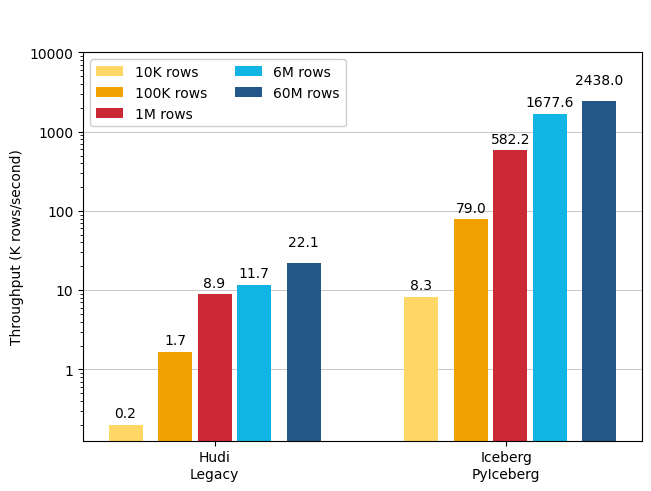

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3124419606.py:47: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3124419606.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


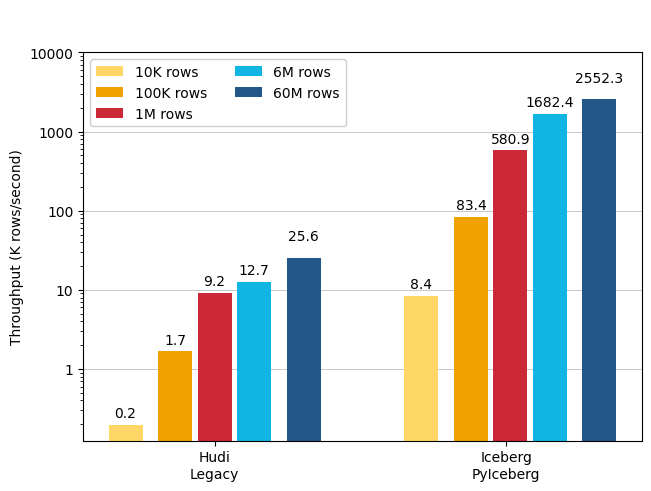

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3124419606.py:47: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3124419606.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


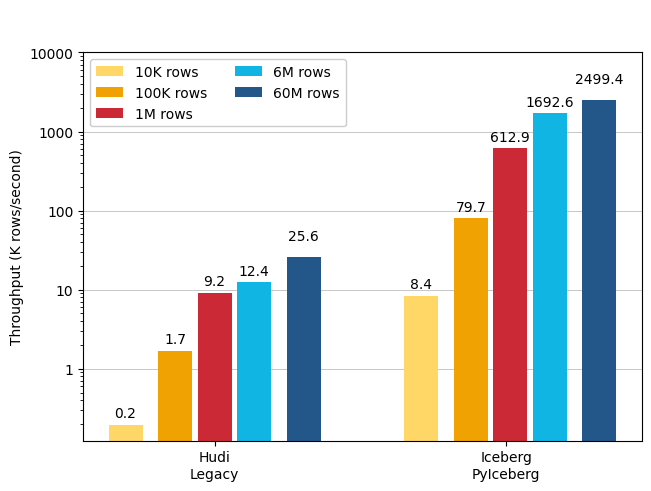

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3124419606.py:47: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3124419606.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


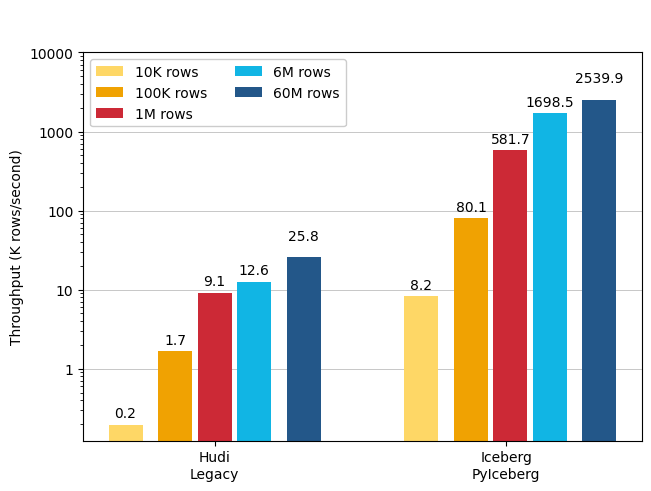

In [43]:
# Read csv file
df = pd.read_csv(data_path / "write" / "write_throughput_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[
        (df["CPU_Cores"] == CPU_config) & (df['Technology'].isin(tech_list))
    ].copy().reset_index(drop=True)

    write_means = {
        '10K rows':  (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5]),
        '100K rows': (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6]), 
        '1M rows':   (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.1f}".format(float(x / 1000)), padding= 3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Throughput (K rows/second)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper left', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 10000000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)
    
    plt.savefig(str(figures_path / 'write'/ dest_folder / "write_throughput_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

#### Read Operations - Throughput

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1040894502.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1040894502.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


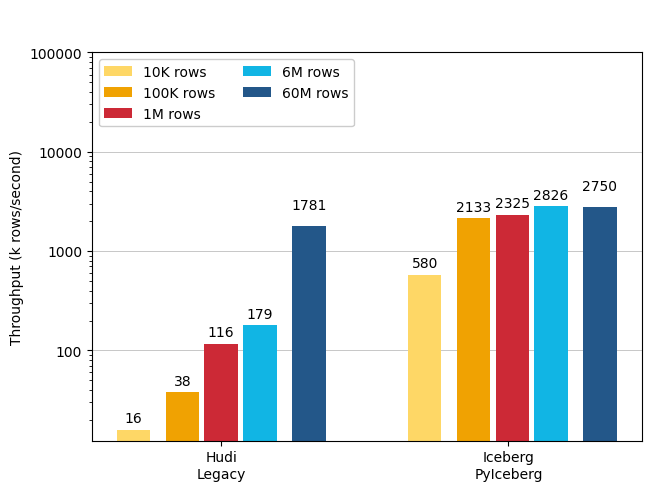

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1040894502.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1040894502.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


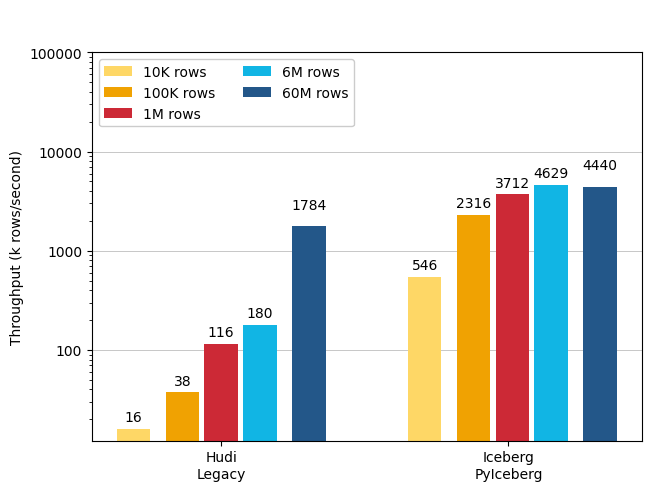

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1040894502.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1040894502.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


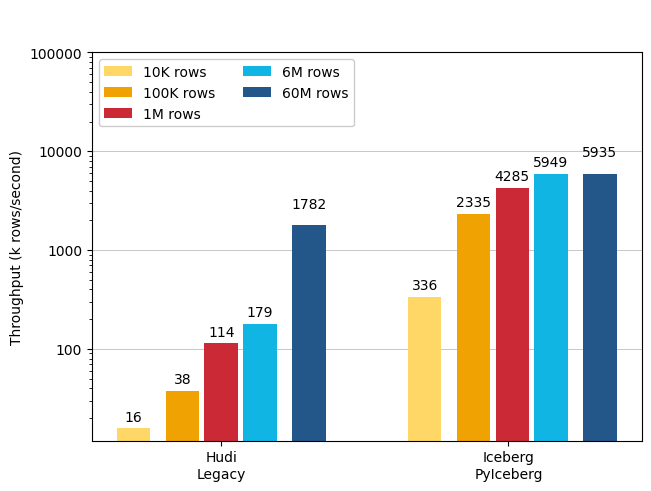

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1040894502.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1040894502.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


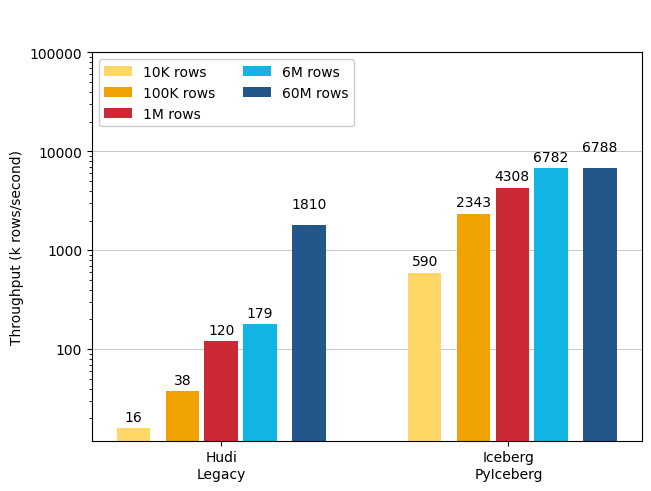

In [55]:
# Read csv file
df = pd.read_csv(data_path / "read" / "read_throughput_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[
        (df["CPU_Cores"] == CPU_config) & (df['Technology'].isin(tech_list))
    ].copy().reset_index(drop=True)

    write_means = {
        '10K rows':  (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5]),
        '100K rows': (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6]), 
        '1M rows':   (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.0f}".format(float(x / 1000)), padding=3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Throughput (k rows/second)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper left', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 100000000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)

    plt.savefig(str(figures_path / 'read'/ dest_folder / "read_throughput_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

### Time/Latency metric on read and writes

#### Write operations - Time/Latency

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4238528873.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4238528873.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


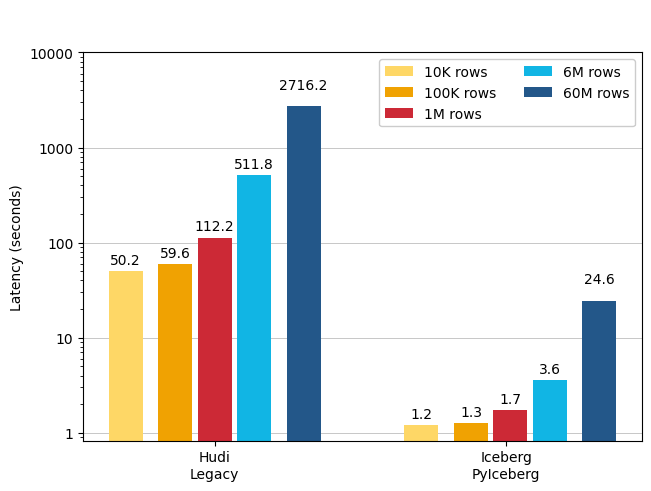

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4238528873.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4238528873.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


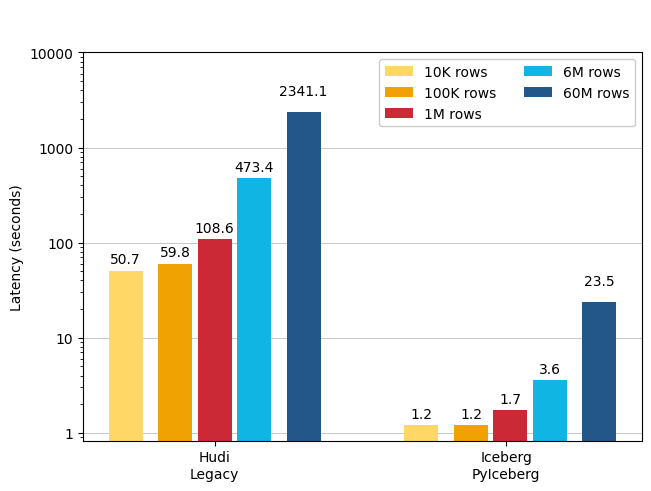

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4238528873.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4238528873.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


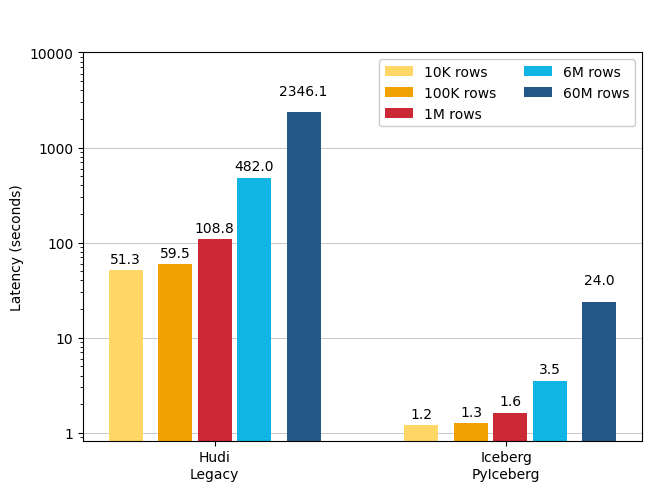

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4238528873.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4238528873.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


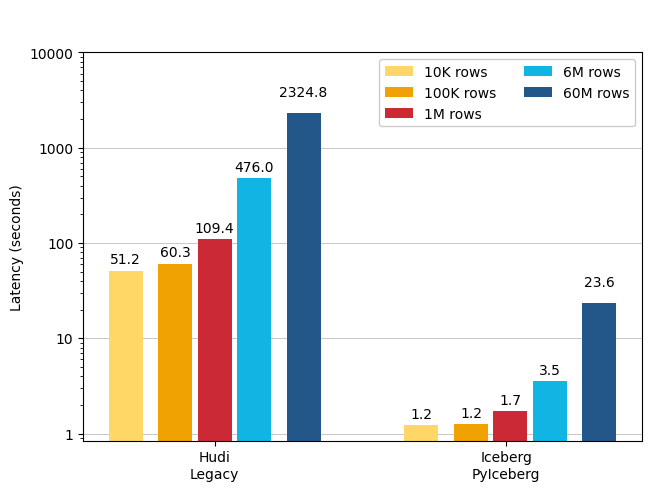

In [57]:
# Read csv file
df = pd.read_csv(data_path / "write" / "write_time_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[
        (df["CPU_Cores"] == CPU_config) & (df['Technology'].isin(tech_list))
    ].copy().reset_index(drop=True)

    write_means = {
        '10K rows':  (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5]),
        '100K rows': (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6]), 
        '1M rows':   (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.1f}".format(float(x)), padding= 3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Latency (seconds)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper right', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 10000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)
    
    plt.savefig(str(figures_path / 'write'/ dest_folder / "write_time_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

#### Read Operations - Time/Latency

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3260840701.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3260840701.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


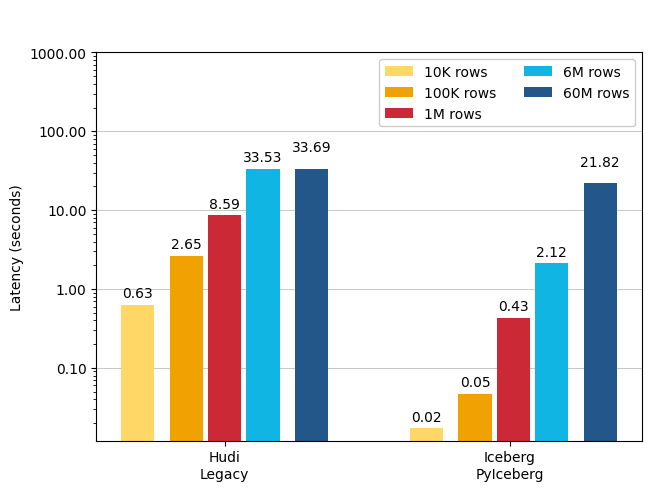

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3260840701.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3260840701.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


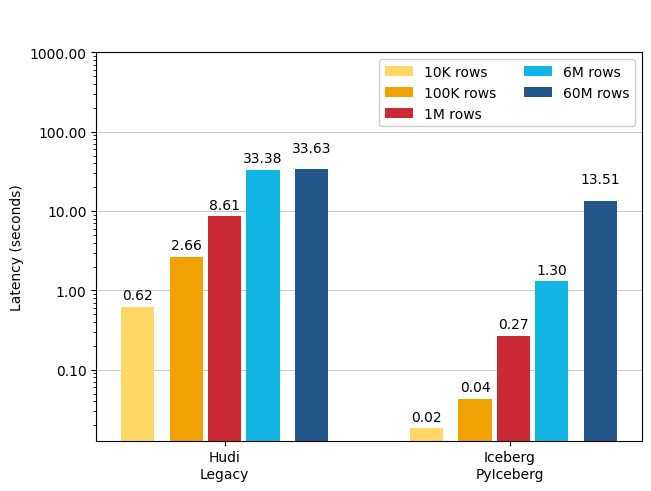

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3260840701.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3260840701.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


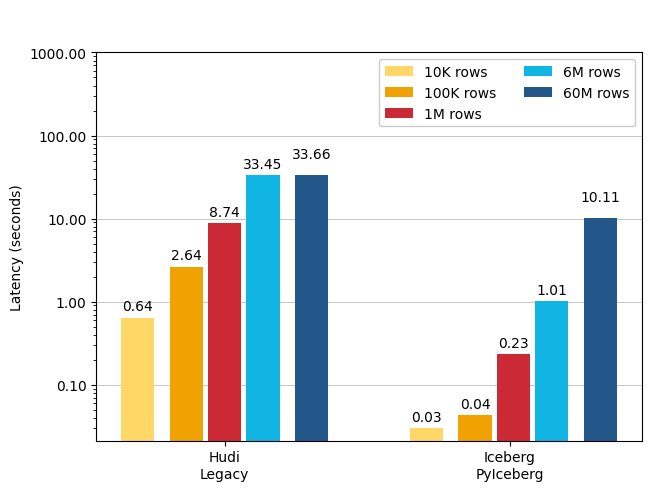

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3260840701.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\3260840701.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


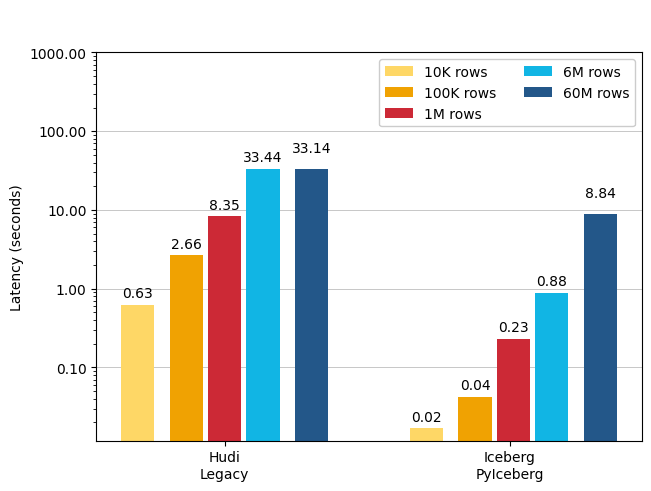

In [58]:
# Read csv file
df = pd.read_csv(data_path / "read" / "read_time_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[
        (df["CPU_Cores"] == CPU_config) & (df['Technology'].isin(tech_list))
    ].copy().reset_index(drop=True)

    write_means = {
        '10K rows':  (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5]),
        '100K rows': (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6]), 
        '1M rows':   (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.2f}".format(float(x)), padding= 3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Latency (seconds)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper right', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 1000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)
    
    plt.savefig(str(figures_path / 'read'/ dest_folder / "read_time_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

## Display results - Iceberg vs. Delta

In [62]:
dest_folder  = 'iceberg_delta'
technologies = ("Iceberg\nPyIceberg","Delta Lake\ndelta-rs")
tech_list    = ['ICEBERG','DELTA']

### Throughput metric on Read and Writes

#### Write operations - Throughput

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4249703122.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4249703122.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


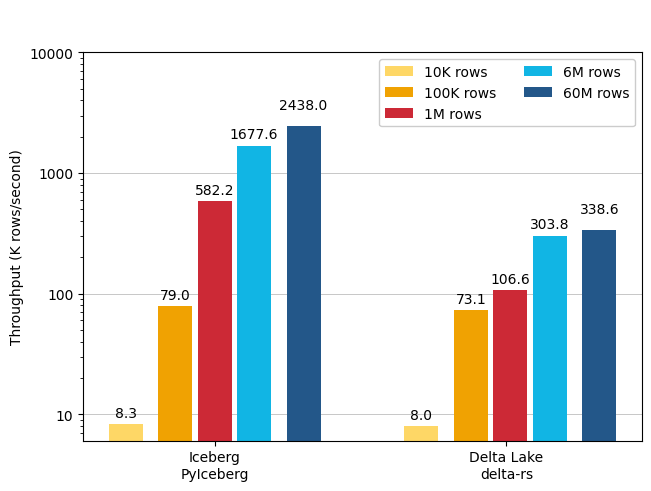

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4249703122.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4249703122.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


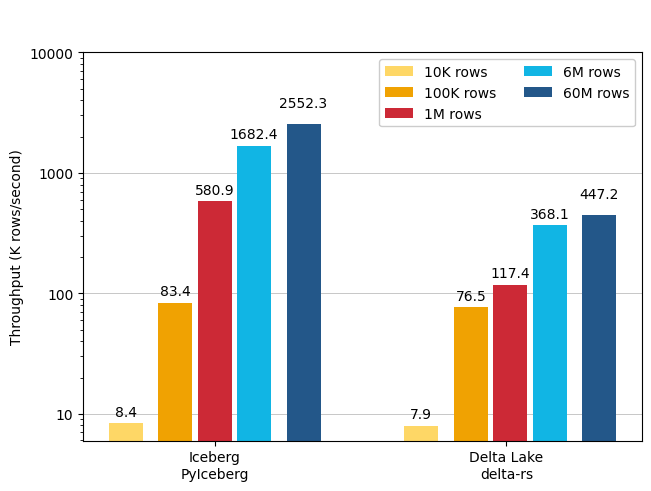

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4249703122.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4249703122.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


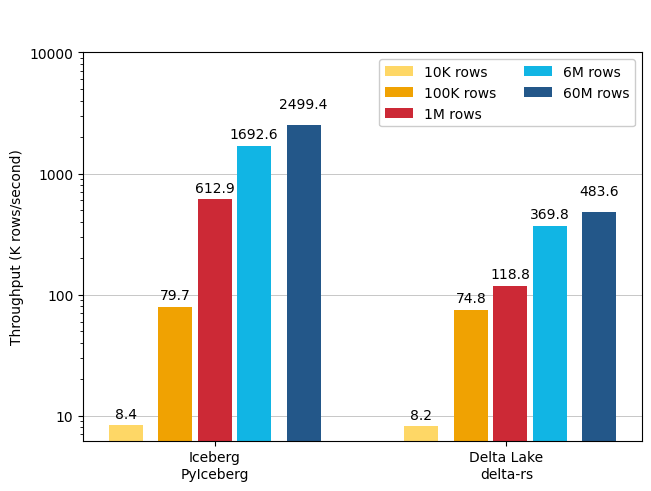

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4249703122.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\4249703122.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


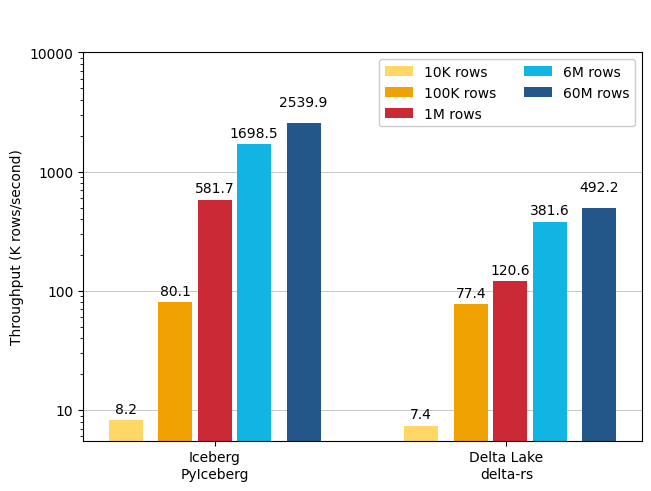

In [64]:
# Read csv file
df = pd.read_csv(data_path / "write" / "write_throughput_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[
        (df["CPU_Cores"] == CPU_config) & (df['Technology'].isin(tech_list))
    ].copy().reset_index(drop=True)

    write_means = {
        '10K rows':  (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5]),
        '100K rows': (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6]), 
        '1M rows':   (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.1f}".format(float(x / 1000)), padding= 3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Throughput (K rows/second)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper right', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 10000000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)
    
    plt.savefig(str(figures_path / 'write'/ dest_folder / "write_throughput_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

#### Read Operations - Throughput

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\587277337.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\587277337.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


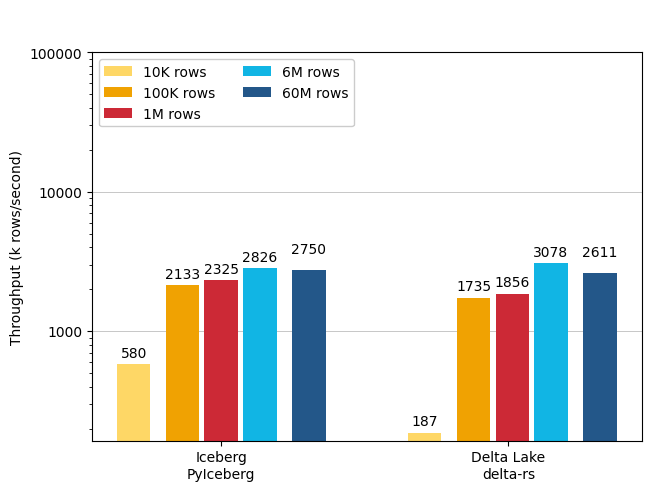

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\587277337.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\587277337.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


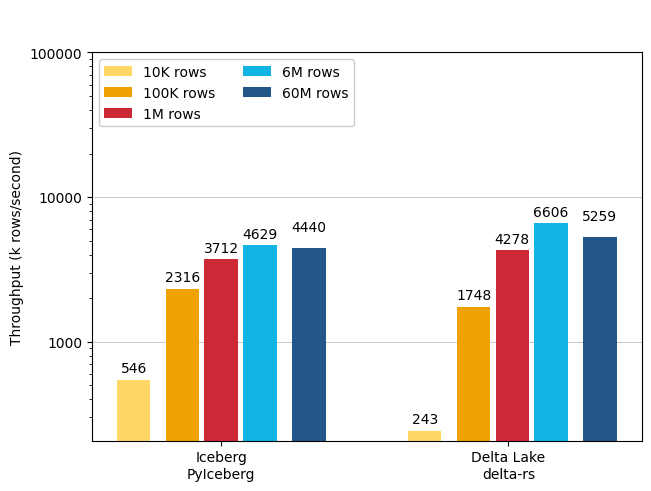

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\587277337.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\587277337.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


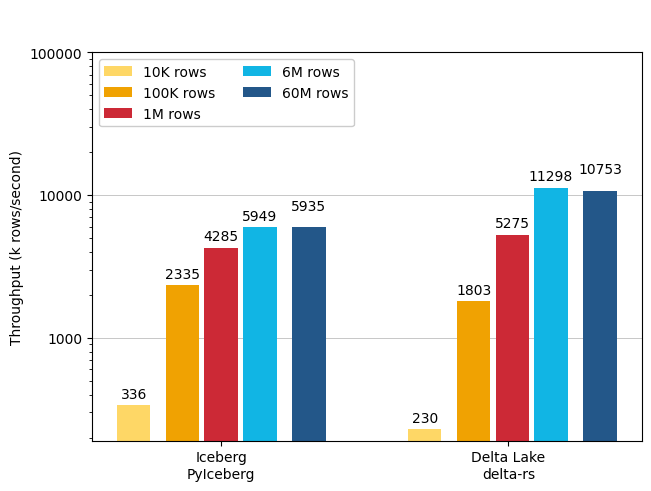

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\587277337.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100000000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\587277337.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


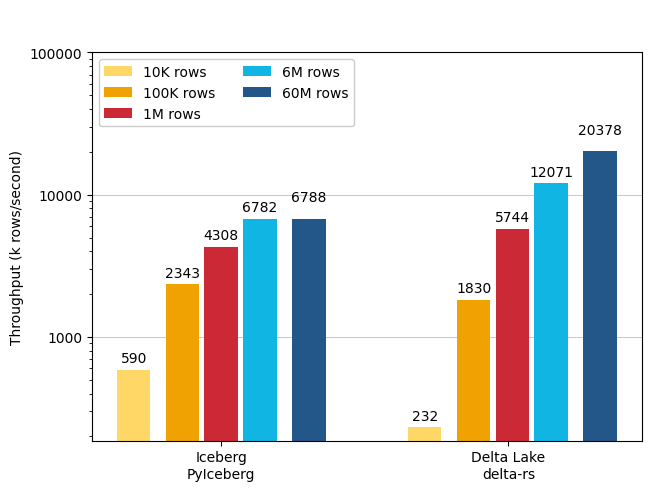

In [65]:
# Read csv file
df = pd.read_csv(data_path / "read" / "read_throughput_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[
        (df["CPU_Cores"] == CPU_config) & (df['Technology'].isin(tech_list))
    ].copy().reset_index(drop=True)

    write_means = {
        '10K rows':  (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5]),
        '100K rows': (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6]), 
        '1M rows':   (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.0f}".format(float(x / 1000)), padding=3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Throughput (k rows/second)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper left', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 100000000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)

    plt.savefig(str(figures_path / 'read'/ dest_folder / "read_throughput_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

### Time/Latency metric on read and writes

#### Write operations - Time/Latency

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1326364890.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1326364890.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


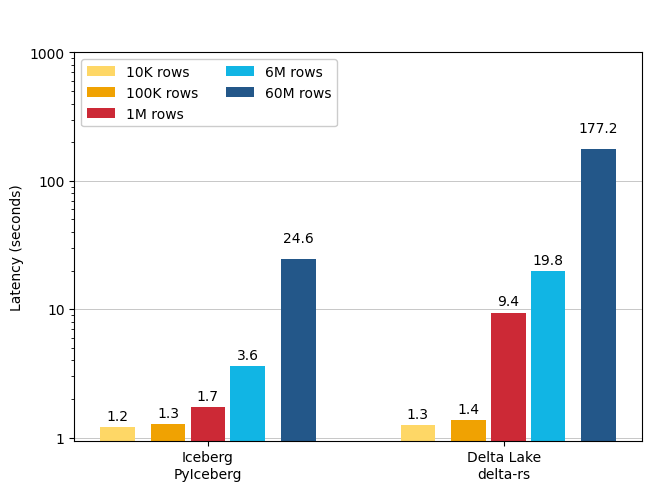

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1326364890.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1326364890.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


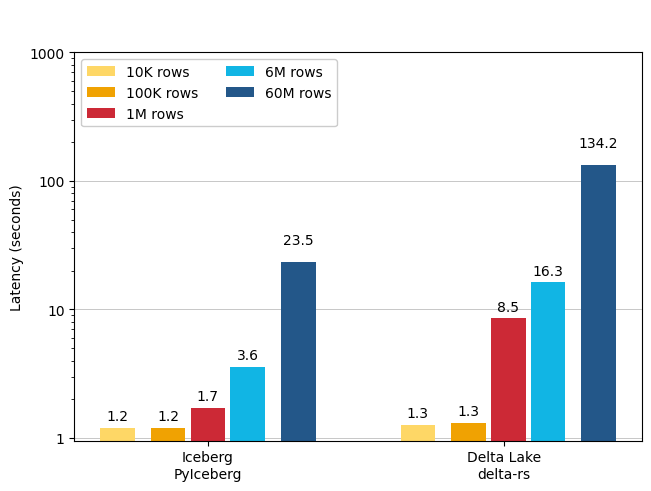

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1326364890.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1326364890.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


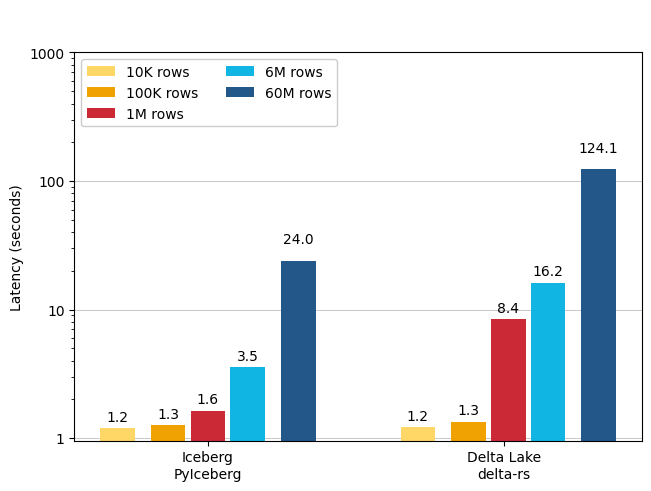

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1326364890.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\1326364890.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])


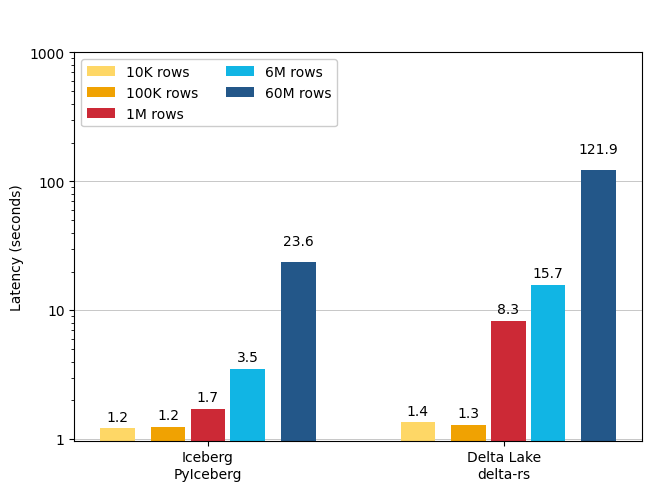

In [67]:
# Read csv file
df = pd.read_csv(data_path / "write" / "write_time_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[
        (df["CPU_Cores"] == CPU_config) & (df['Technology'].isin(tech_list))
    ].copy().reset_index(drop=True)

    write_means = {
        '10K rows':  (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5]),
        '100K rows': (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6]), 
        '1M rows':   (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.1f}".format(float(x)), padding= 3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Latency (seconds)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper left', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 1000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(["{:.0f}".format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)
    
    plt.savefig(str(figures_path / 'write'/ dest_folder / "write_time_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()

#### Read Operations - Time/Latency

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\128626751.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\128626751.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


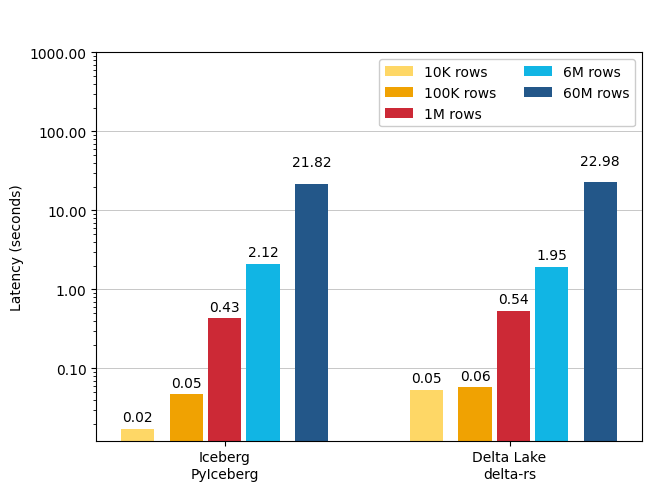

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\128626751.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\128626751.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


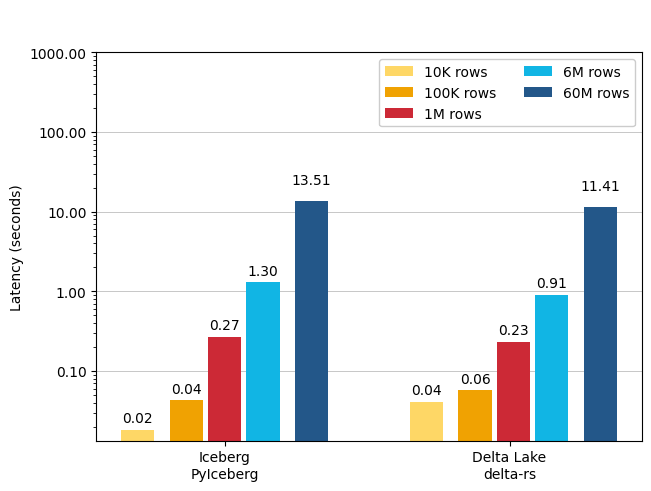

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\128626751.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\128626751.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


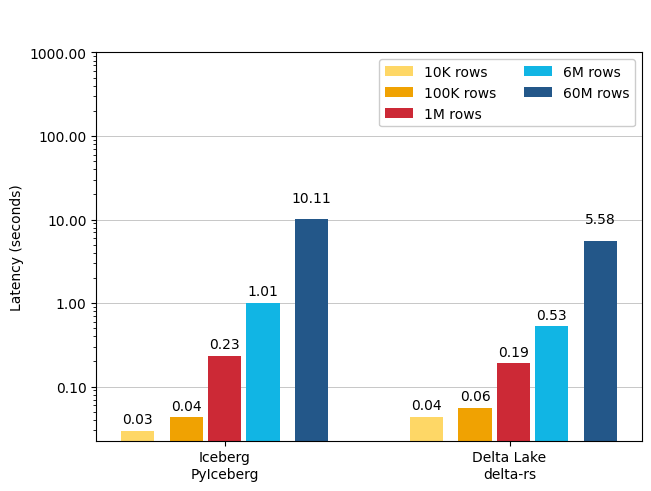

C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\128626751.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)
C:\Users\meneghs\AppData\Local\Temp\ipykernel_26748\128626751.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])


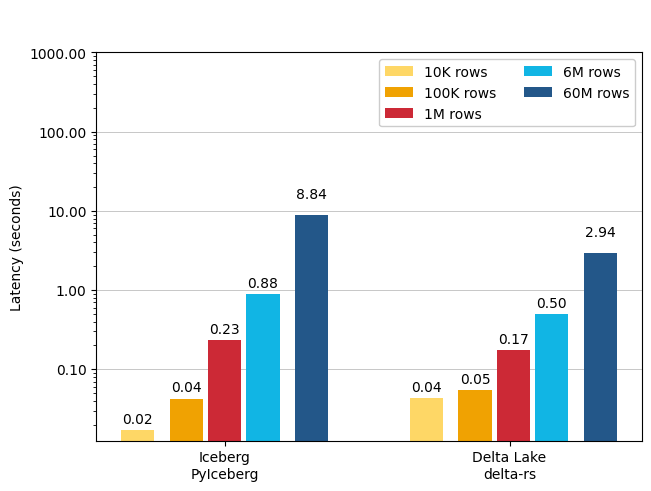

In [68]:
# Read csv file
df = pd.read_csv(data_path / "read" / "read_time_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[
        (df["CPU_Cores"] == CPU_config) & (df['Technology'].isin(tech_list))
    ].copy().reset_index(drop=True)

    write_means = {
        '10K rows':  (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5]),
        '100K rows': (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6]), 
        '1M rows':   (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7]),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8]),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9]),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.34, -0.15, 0, 0.15, 0.34]  # offsets for each bar
    np_offsets = np.array([0, 0.115])

    fig, ax = plt.subplots(layout='constrained')

    paddings = {0: 0, 1: 0, 2: 0, 3: 0, 4: 7,}

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.2f}".format(float(x)), padding= 3 + paddings[multiplier])
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Latency (seconds)')
    ax.set_title(' \n')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper right', ncols=2, framealpha=1)

    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    ax.set_ylim(0, 1000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(["{:.2f}".format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)
    
    plt.savefig(str(figures_path / 'read'/ dest_folder / "read_time_") + CPU_config + ".png", bbox_inches="tight")
    plt.show()